In [1]:
# Installation des packages
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn
!pip install scipy
!pip install --user missingno
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [2]:
# Importation des librairies
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import sklearn as sk
import scipy as sc
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from scipy import stats
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import spearmanr
from statsmodels.formula.api import ols

In [3]:
# Chargement des données nettoyés
data = pd.read_excel("P3_data.xlsx")
target_cible = pd.read_excel("P3_target_cible.xlsx")

# Création d'une série ne contenant que la variable cible
serie_cible = target_cible["calcium_100g"]

print(serie_cible.head())

0    0.000
1    0.071
2    0.143
3    0.062
4    0.133
Name: calcium_100g, dtype: float64


In [4]:
data.describe()

code      energy_kj       fat_100g  saturated-fat_100g  \
count  1.308030e+05  130803.000000  130803.000000       130803.000000   
mean   5.343425e+12    1209.388804      12.818706            4.026122   
std    7.944793e+14     740.111674      13.879119            4.974658   
min    2.100000e+01       0.000000       0.000000            0.000000   
25%    4.126811e+10     494.000000       0.810000            0.000000   
50%    7.469009e+10    1264.000000       7.690000            1.770000   
75%    7.222523e+11    1761.000000      21.430000            7.000000   
max    1.285057e+17    3661.000000      52.220000           17.810000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count       130803.000000  130803.000000  130803.000000  130803.000000   
mean            35.496129      14.094525       2.144002       7.236205   
std             28.194688      16.533414       2.353426       6.425833   
min              0.000000       0.000000       0.000000       0.000000   
25%              9.000000       1.630000       0.000000       2.350000   
50%             28.570000       5.830000       1.500000       5.620000   
75%             60.710000      23.680000       3.600000      10.710000   
max            100.000000      58.330000       9.000000      24.000000   

         sodium_100g   calcium_100g      iron_100g  nutrition-score-fr_100g  
count  130803.000000  130803.000000  130803.000000            130803.000000  
mean        0.343047       0.048608       0.001336                10.457661  
std         0.319830       0.057370       0.001423                 7.844564  
min         0.000000       0.000000       0.000000                 0.000000  
25%         0.054000       0.000000       0.000000                 2.600000  
50%         0.282000       0.028000       0.000960                10.000000  
75%         0.536000       0.078000       0.002250                16.000000  
max         1.343000       0.250000       0.006000                37.000000

In [5]:
data["code"] = data["code"].astype("object")

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130803 entries, 0 to 130802
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   code                     130803 non-null  object 
 1   product_name             130803 non-null  object 
 2   energy_kj                130803 non-null  float64
 3   fat_100g                 130803 non-null  float64
 4   saturated-fat_100g       130803 non-null  float64
 5   carbohydrates_100g       130803 non-null  float64
 6   sugars_100g              130803 non-null  float64
 7   fiber_100g               130803 non-null  float64
 8   proteins_100g            130803 non-null  float64
 9   sodium_100g              130803 non-null  float64
 10  calcium_100g             130803 non-null  float64
 11  iron_100g                130803 non-null  float64
 12  nutrition_grade_fr       130803 non-null  object 
 13  nutrition-score-fr_100g  130803 non-null  float64
dtypes: f

In [7]:
target_cible.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130803 entries, 0 to 130802
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   code          130803 non-null  int64  
 1   calcium_100g  130803 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [8]:
target_cible.describe()

code   calcium_100g
count  1.308030e+05  130803.000000
mean   5.343425e+12       0.048608
std    7.944793e+14       0.057370
min    2.100000e+01       0.000000
25%    4.126811e+10       0.000000
50%    7.469009e+10       0.028000
75%    7.222523e+11       0.078000
max    1.285057e+17       0.250000

In [9]:
target_cible.isna().sum()

code            0
calcium_100g    0
dtype: int64

------Etape 4 : Effectuez les analyse univariée et bi-variée------

L’objectif de cette étape est de mieux comprendre les distributions des variables nutritionnelles présentes dans la base de données, d’observer les liens entre ces variables (en particulier avec le Nutri-Score et la teneur en calcium), et d’identifier les éléments pertinents pour la future auto-complétion ou modélisation.

réalisé une analyse univariée complète de chaque feature (variable) de l' ensemble de données

In [10]:
# Ajout de la variable cible au dataframe
data = data.drop(columns=["calcium_100g"])
data["variable_cible(calcium_100g)"] = serie_cible

In [11]:
features_cat = data.select_dtypes(exclude = ["number"])
features_num = data.select_dtypes(include = ["number"])

if "code" in features_num.columns :
    num_features = features_num.drop(columns = ["code"])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130803 entries, 0 to 130802
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   code                          130803 non-null  object 
 1   product_name                  130803 non-null  object 
 2   energy_kj                     130803 non-null  float64
 3   fat_100g                      130803 non-null  float64
 4   saturated-fat_100g            130803 non-null  float64
 5   carbohydrates_100g            130803 non-null  float64
 6   sugars_100g                   130803 non-null  float64
 7   fiber_100g                    130803 non-null  float64
 8   proteins_100g                 130803 non-null  float64
 9   sodium_100g                   130803 non-null  float64
 10  iron_100g                     130803 non-null  float64
 11  nutrition_grade_fr            130803 non-null  object 
 12  nutrition-score-fr_100g       130803 non-nul

In [13]:
data.describe()

energy_kj       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  130803.000000  130803.000000       130803.000000       130803.000000   
mean     1209.388804      12.818706            4.026122           35.496129   
std       740.111674      13.879119            4.974658           28.194688   
min         0.000000       0.000000            0.000000            0.000000   
25%       494.000000       0.810000            0.000000            9.000000   
50%      1264.000000       7.690000            1.770000           28.570000   
75%      1761.000000      21.430000            7.000000           60.710000   
max      3661.000000      52.220000           17.810000          100.000000   

         sugars_100g     fiber_100g  proteins_100g    sodium_100g  \
count  130803.000000  130803.000000  130803.000000  130803.000000   
mean       14.094525       2.144002       7.236205       0.343047   
std        16.533414       2.353426       6.425833       0.319830   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.630000       0.000000       2.350000       0.054000   
50%         5.830000       1.500000       5.620000       0.282000   
75%        23.680000       3.600000      10.710000       0.536000   
max        58.330000       9.000000      24.000000       1.343000   

           iron_100g  nutrition-score-fr_100g  variable_cible(calcium_100g)  
count  130803.000000            130803.000000                 130803.000000  
mean        0.001336                10.457661                      0.048608  
std         0.001423                 7.844564                      0.057370  
min         0.000000                 0.000000                      0.000000  
25%         0.000000                 2.600000                      0.000000  
50%         0.000960                10.000000                      0.028000  
75%         0.002250                16.000000                      0.078000  
max         0.006000                37.000000                      0.250000

In [14]:
target_cible.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130803 entries, 0 to 130802
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   code          130803 non-null  int64  
 1   calcium_100g  130803 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [15]:
target_cible.describe()

code   calcium_100g
count  1.308030e+05  130803.000000
mean   5.343425e+12       0.048608
std    7.944793e+14       0.057370
min    2.100000e+01       0.000000
25%    4.126811e+10       0.000000
50%    7.469009e+10       0.028000
75%    7.222523e+11       0.078000
max    1.285057e+17       0.250000

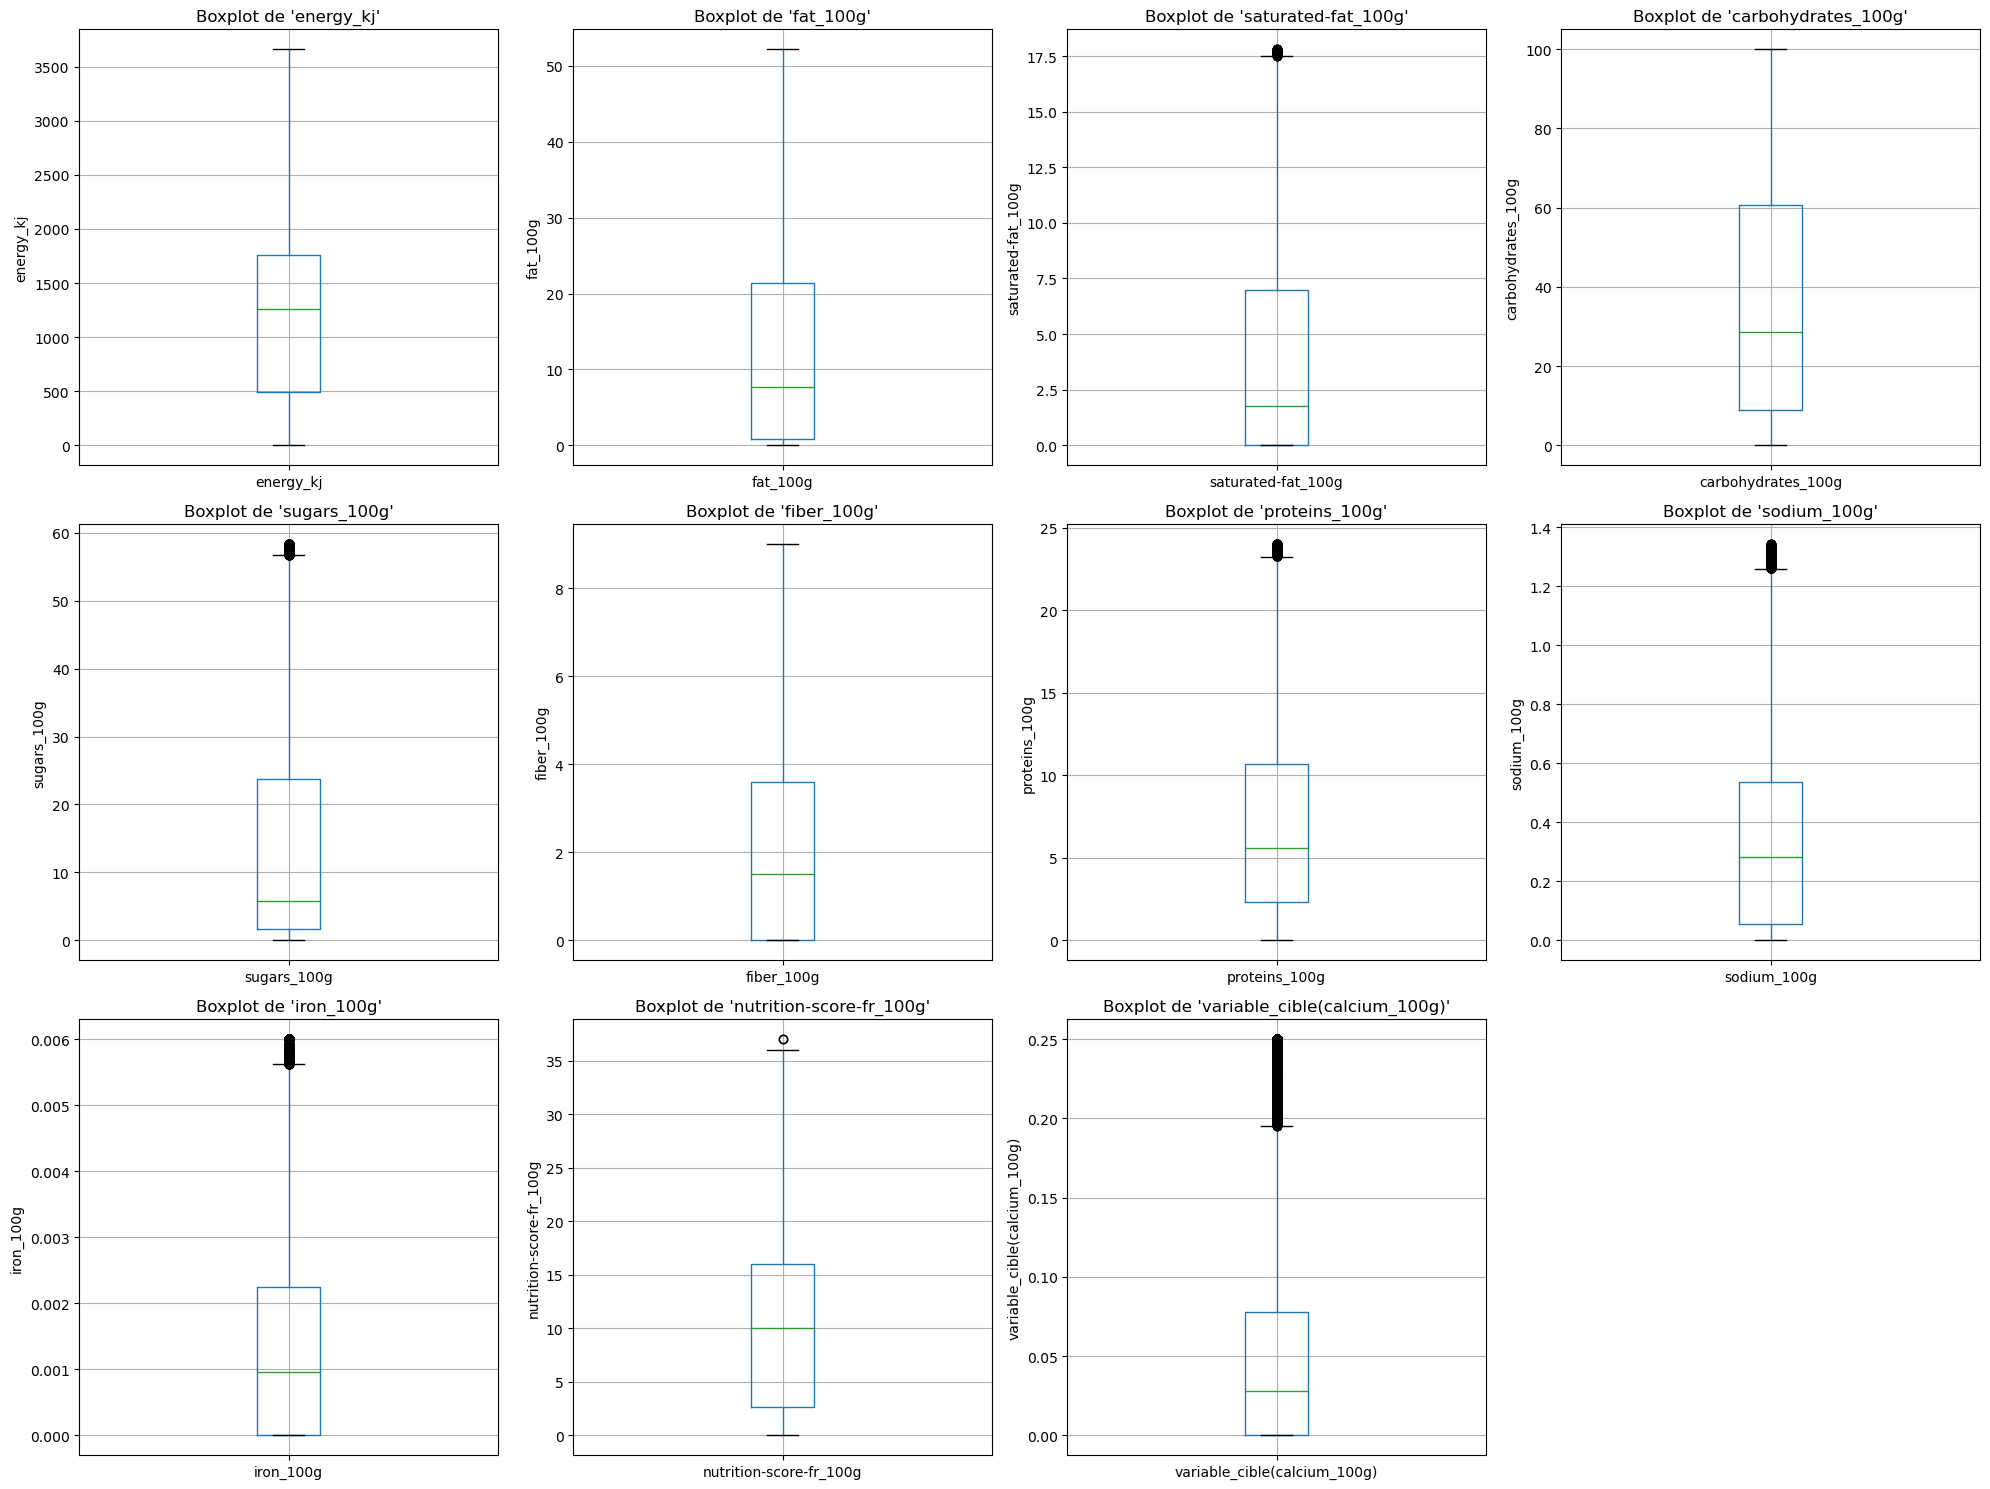

In [16]:
# boxplots: visualiser les distributions de toutes les variables numériques

num_vars = len(features_num.columns)
num_cols = 4
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize = (20, 5 * num_rows))
axes = axes.flatten()

for i, var in enumerate(features_num.columns) :
    features_num.boxplot(column = var, ax = axes[i])
    axes[i].set_title(f"Boxplot de '{var}'")
    axes[i].set_ylabel(var)

for i in range(num_vars, len(axes)) :
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

La majorité des variables présentent des asymétries positives (longue queue à droite).

Plusieurs variables, notamment sugars_100g, proteins_100g, calcium_100g, comportent des outliers clairement visibles.

Ces résultats confirment la nécessité de nettoyage (IQR, bornes logiques) ou d’un traitement robuste (RobustScaler) avant l’analyse ou la modélisation.

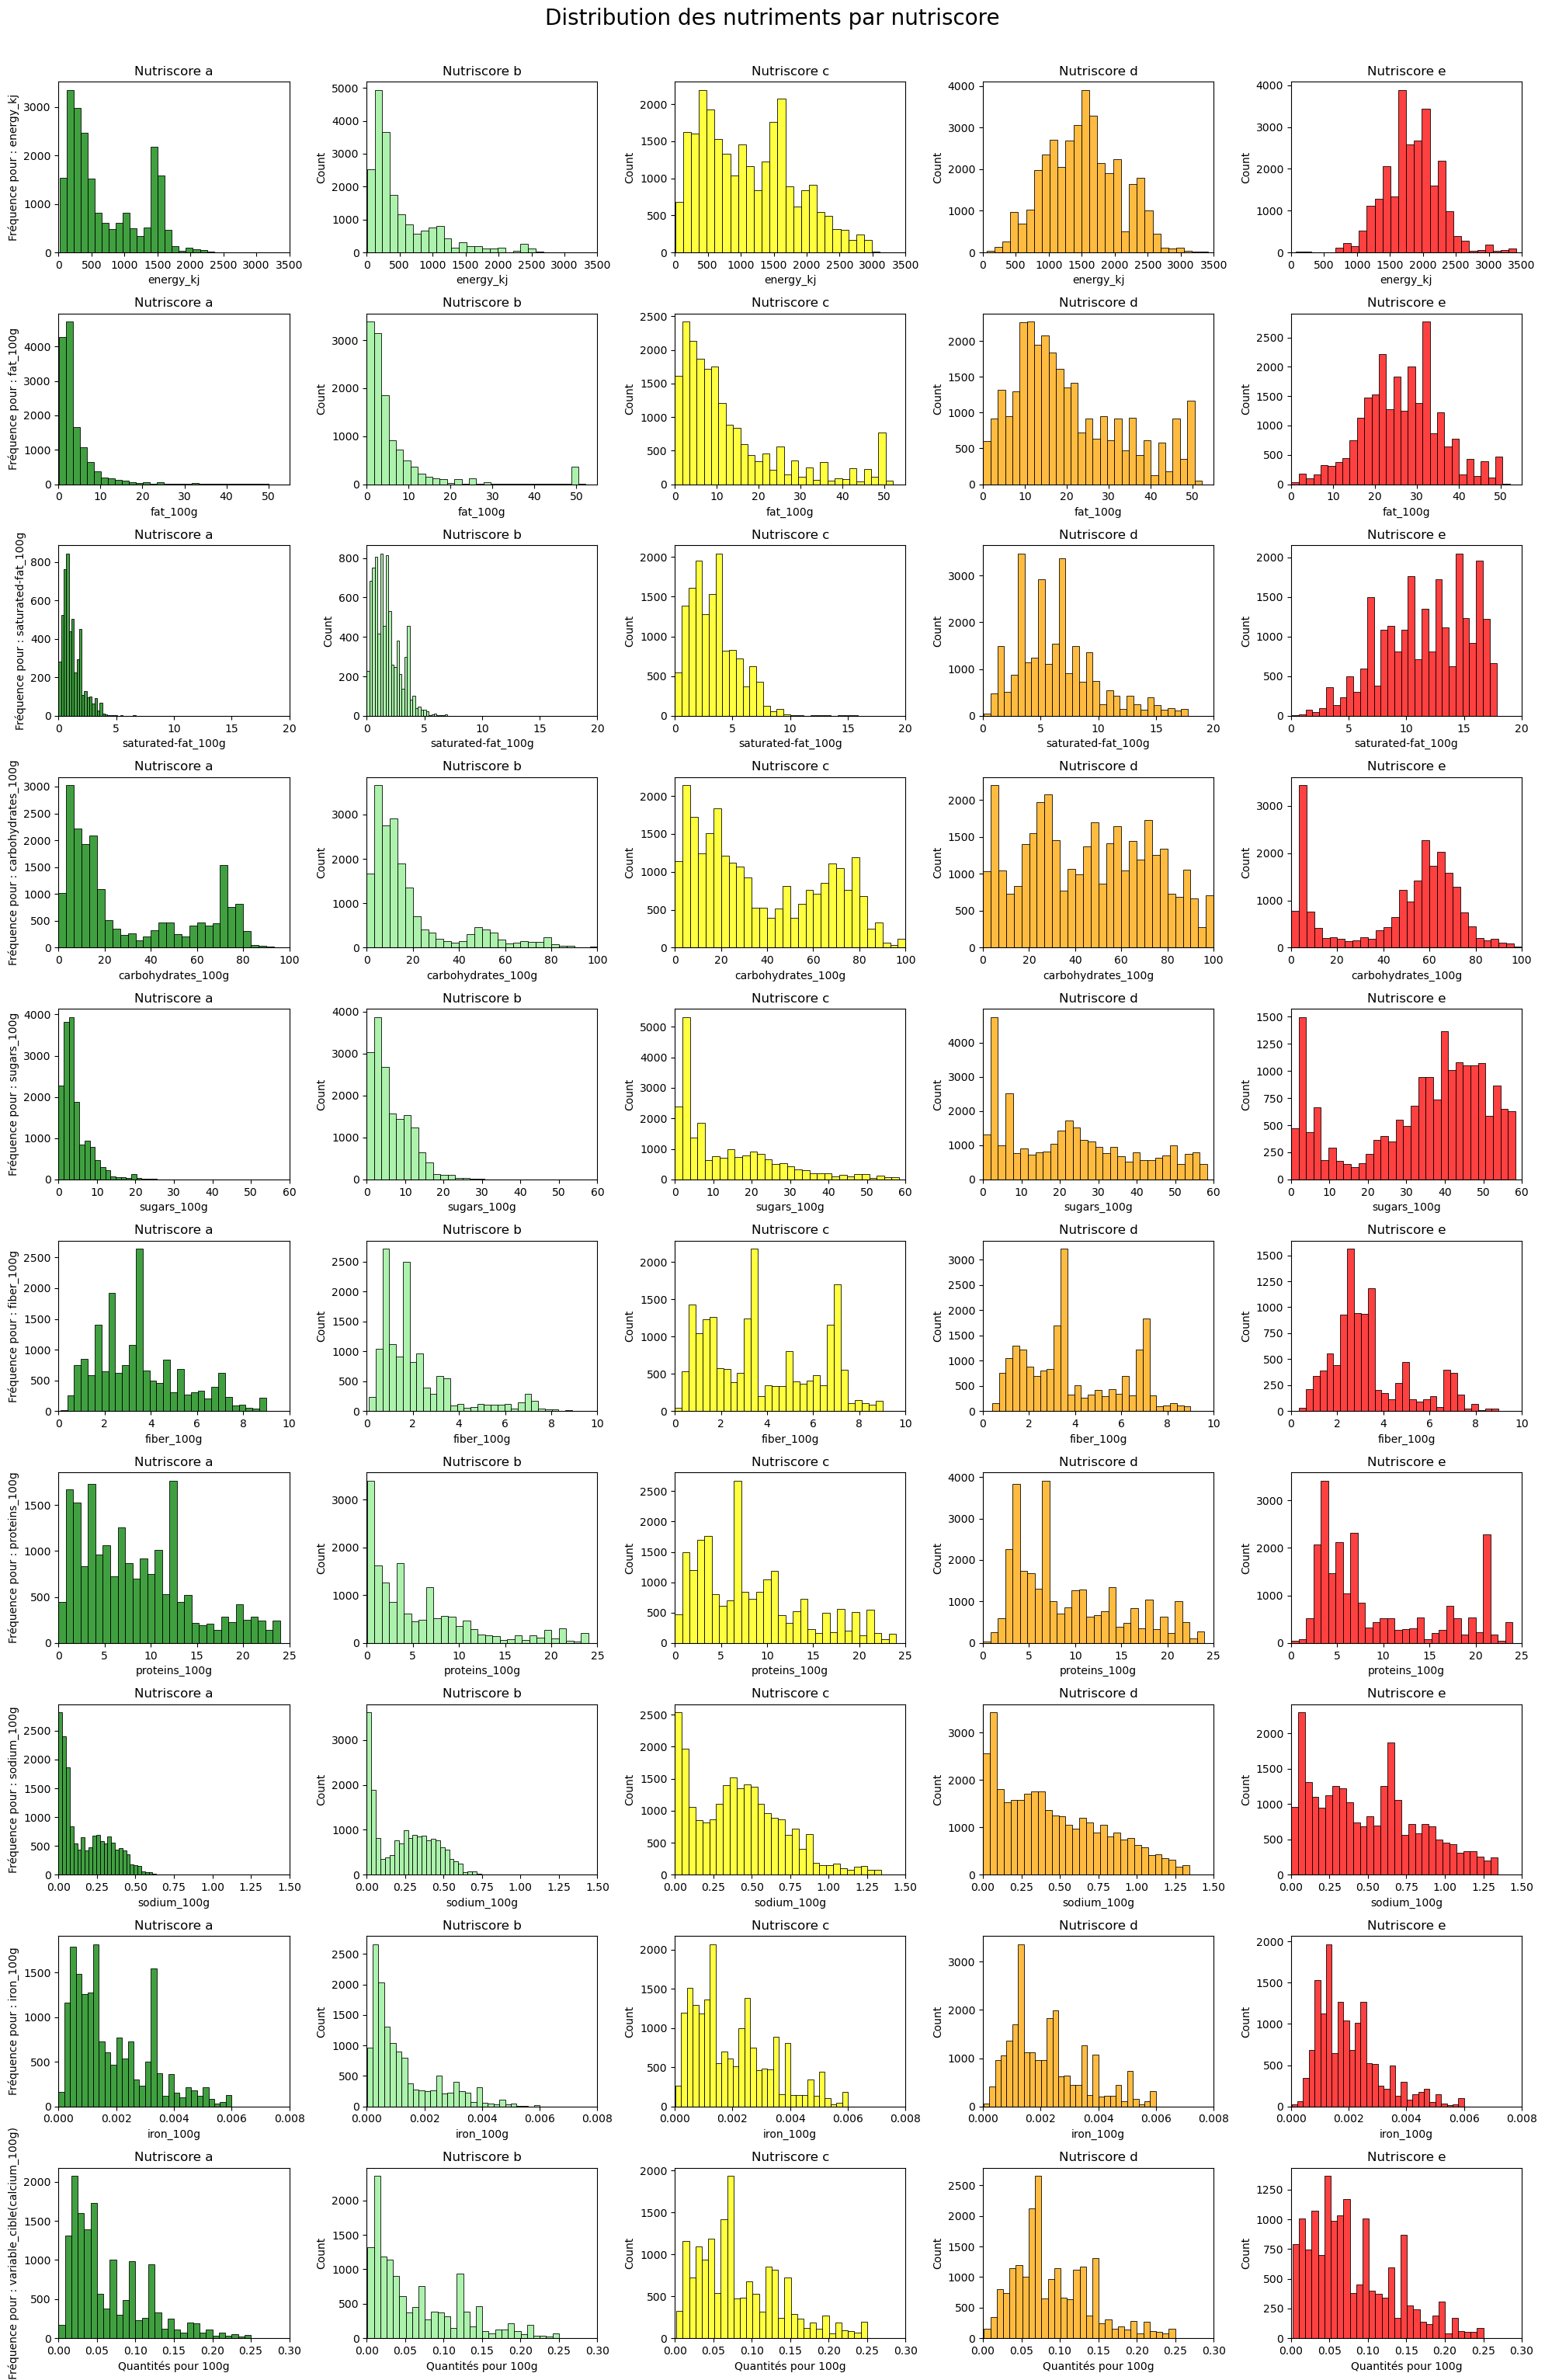

In [17]:
# Définir les nutriments à visualiser
nutriments = ["energy_kj", "fat_100g", "saturated-fat_100g",
            "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g",
            "sodium_100g", "iron_100g", "variable_cible(calcium_100g)"]

# Définir les couleurs pour chaque groupe Nutri-Score
colors = {
    "a": "green",
    "b": "lightgreen",
    "c": "yellow",
    "d": "orange",
    "e": "red"
}

# Créer une figure et des sous-graphiques pour chaque nutriment
fig, axes = plt.subplots(10, 5, figsize=(20, 30), sharex=False, sharey=False)

# Limites pour chaque nutriment basées sur les données
limits = {
    "energy_kj": (0, 3500),
    "fat_100g": (0, 55),
    "saturated-fat_100g": (0, 20),
    "carbohydrates_100g": (0, 100),
    "sugars_100g": (0, 60),
    "fiber_100g": (0, 10),
    "proteins_100g": (0, 25),
    "sodium_100g": (0, 1.5),
    "iron_100g": (0, 0.008),
    "variable_cible(calcium_100g)": (0, 0.30)
}

# Parcourir les nutriments et les groupes Nutri-Score
for i, nutriment in enumerate(nutriments):
    for j, grade in enumerate(["a", "b", "c", "d", "e"]):
        ax = axes[i, j]

        # Filtrer les valeurs nulles ou proches de zéro
        data_filtered = data[data["nutrition_grade_fr"] == grade][nutriment]
        data_filtered = data_filtered[data_filtered > 0]

        sns.histplot(data_filtered, ax=ax, color=colors[grade], kde=False, bins=30)
        ax.set_title(f"Nutriscore {grade}")
        if j == 0:
            ax.set_ylabel("Fréquence pour : " + nutriment)
        if i == 9:
            ax.set_xlabel("Quantités pour 100g")

        # Ajuster les échelles selon les limites calculées
        ax.set_xlim(limits[nutriment])

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.suptitle("Distribution des nutriments par nutriscore", y=1.02, fontsize=20)
plt.show()

Conclusions par groupe de Nutri-Score :

Nutri-Score A : Les produits ayant un Nutri-Score A se caractérisent par des faibles niveaux de calories, graisses saturées, sucres et sodium. Ils sont riches en fibres et contiennent une quantité modérée de protéines.

Nutri-Score B : Les produits avec un Nutri-Score B ont une légère augmentation des niveaux de calories, graisses saturées, et sucres par rapport au Nutri-Score A, mais restent encore relativement sains. Les niveaux de fibres sont similaires à ceux du Nutri-Score A, et les protéines varient également, mais restent dans des gammes acceptables.

Nutri-Score C : Le Nutri-Score C montre une augmentation notable dans les niveaux de calories, graisses saturées, et sucres. Les fibres commencent à diminuer, ce qui indique une qualité nutritionnelle moindre. Les protéines restent variables, mais la tendance générale montre une diminution de la qualité nutritionnelle globale par rapport aux Nutri-Scores A et B.

Nutri-Score D : Les produits classés Nutri-Score D ont des niveaux encore plus élevés de calories, graisses saturées, sucres, et sodium. Les fibres sont considérablement réduites, ce qui indique une diminution importante de la qualité nutritionnelle.

Nutri-Score E : Les produits avec un Nutri-Score E montrent les plus hauts niveaux de calories, graisses saturées, sucres, et sodium, et les plus faibles niveaux 

-----globalement-----: Les aliments Nutri-Score A (vert) ont globalement des valeurs plus faibles en énergie, matières grasses, sucres et sodium, et des valeurs plus élevées en fibres et protéines.

À l’opposé, les Nutri-Score E (rouge) montrent des pics élevés pour les graisses, sucres, sodium, énergie, et des fibres plus faibles.de fibres.

Conclusions par nutriment :

Calories (energy_kj) : Les produits les plus caloriques se trouvent dans les Nutri-Scores D et E. Les Nutri-Scores A et B contiennent des produits beaucoup moins caloriques.

Graisses totales (fat_100g) :La distribution des graisses totales varie de manière plus marquée selon les Nutri-Scores. Les Nutri-Scores A et B contiennent les plus faibles niveaux de graisses totales, le Nutri-Score C présente une augmentation notable des niveaux de graisses totales et les Nutri-Scores D et E montrent les niveaux les plus élevés de graisses.

Graisses saturées (saturated_fat_100g) : Les graisses saturées augmentent significativement du Nutri-Score A au Nutri-Score E. Les produits les plus sains (Nutri-Score A) ont des niveaux très faibles de graisses saturées, tandis que ceux avec un Nutri-Score E en ont le plus.

Glucides (carbohydrates_100g) : La distribution des glucides montre une tendance générale à l'augmentation avec les Nutri-Scores C, D, et E. Les Nutri-Scores A et B ont des glucides modérés, souvent associées à des produits riches en fibres.

Sucres (sugars_100g) : Les sucres suivent une tendance similaire aux glucides, avec des niveaux beaucoup plus élevés dans les Nutri-Scores D et E, et les niveaux les plus bas dans le Nutri-Score A.

Fibres (fiber_100g) : Les fibres sont principalement présentes dans les Nutri-Scores A et B, avec une diminution marquée dans les Nutri-Scores C, D, et E. Cela indique que les produits avec des Nutri-Scores élevés (D, E) sont souvent pauvres en fibres.

Protéines (proteins_100g) : Les protéines sont relativement stables, mais elles sont légèrement plus élevées dans les Nutri-Scores A et B. Les Nutri-Scores C, D, et E montrent une plus grande variabilité, avec une tendance à la diminution de la qualité protéique dans les produits moins sains.

Sodium (sodium_100g) : Le sodium montre une tendance claire à l'augmentation des Nutri-Scores A à E. Les produits avec un Nutri-Score E ont les niveaux les plus élevés de sodium, ce qui est associé à un risque accru de maladies cardiovasculaires.

Fer (iron_100g) : Les niveaux de fer restent relativement constants à travers les différents Nutri-Scores, indiquant que ce nutriment n'est pas particulièrement influencé par la qualité nutritionnelle globale selon le Nutri-Score.

Calcium (calcium_100g) : Les niveaux de calcium restent relativement constants et similaires à travers les différents groupes de Nutri-Score, ave
-----globalement-----: La distribution des nutriments évolue logiquement d’un Nutri-Score favorable (a) à défavorable (e).

Cela valide l’algorithme du Nutri-Score, en particulier pour l’énergie, les graisses, les sucres, le sodium et les fibres.

Les nutriments non pris en compte dans le score comme le fer ou le calcium ne montrent pas de tendance particulière, ce qui est également cohérent.
c quelques variations mineures.

Conclusion global :

Les Nutri-Scores A et B sont associés à des produits plus sains, riches en fibres et modérés en énergie, graisses saturées, sucres, et sodium. Les Nutri-Scores D et E contiennent des produits plus riches en énergie, graisses saturées, sucres, et sodium, avec moins de fibres, indiquant une moins bonne qualité nutritionnelle.

 réalisé une analyse bivariée pour étudier les relations entre différentes paires de features.

In [18]:
# Ajout de la variable cible à cat_features
features_cat["variable_cible(calcium_100g)"] = serie_cible

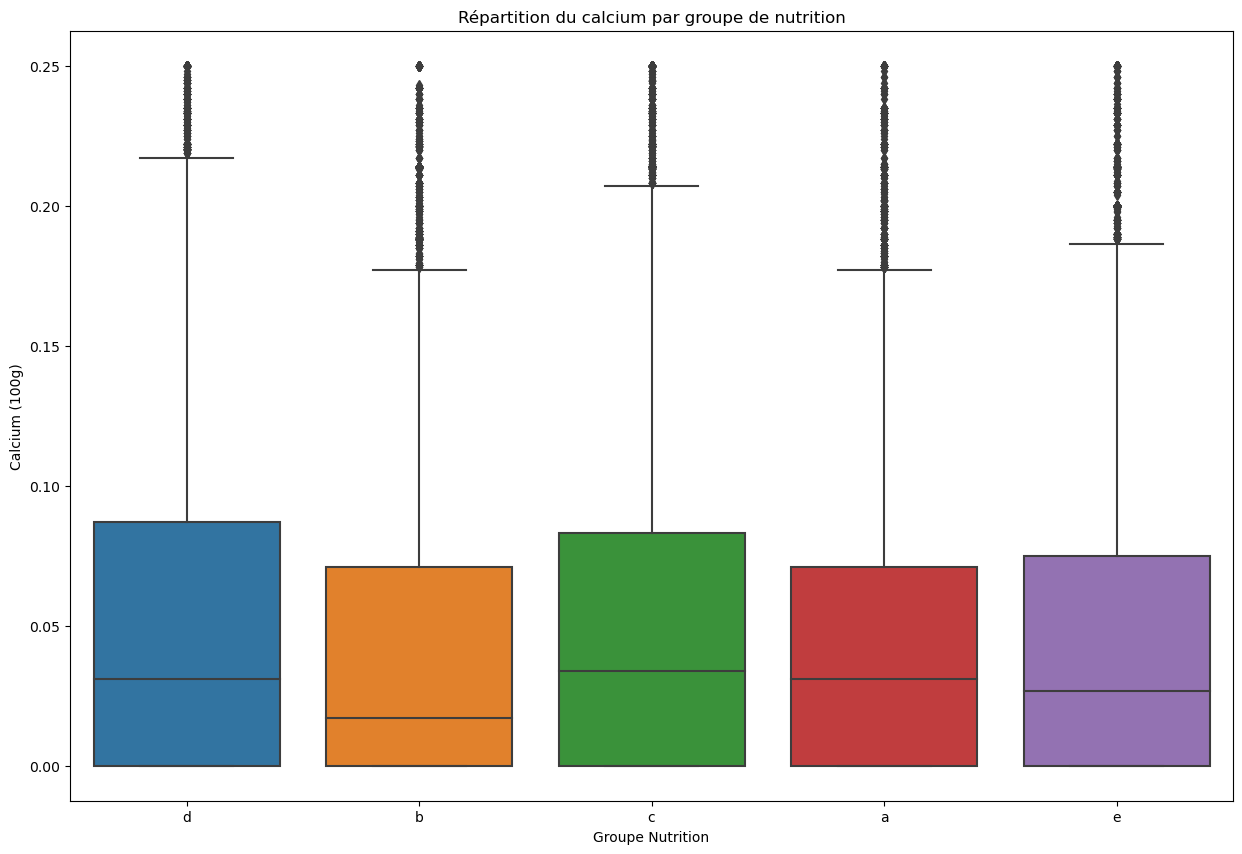

In [19]:
# Répartition du calcium par groupe Nutri-Score

plt.figure(figsize=(15, 10))  # Taille de la figure pour plus de lisibilité
sns.boxplot(x="nutrition_grade_fr", y="variable_cible(calcium_100g)", data=data)

# Ajouter un titre et des labels pour plus de clarté
plt.title("Répartition du calcium par groupe de nutrition")
plt.xlabel("Groupe Nutrition")
plt.ylabel("Calcium (100g)")

# Affichage du graphique
plt.show()

Conclusion pour notre cible le calcium :

Comme on l'a conclu plus haut avec l'histogra:

L la répartition du calcium ne semble pas avoir de corrélation forte avec les groupes de Nutri-Score

. La médiane du calcium est relativement similaire à travers les différents groupes de Nutri-Score, indiquant que le calcium n'est pas un facteur déterminant dans la classification du Nutri-Score

. Cependant, il existe une variabilité importante dans chaque groupe, avec des outliers significatifs, ce qui montre que certains produits, même dans les groupes moins sains (comme D et E), peuvent avoir des niveaux élevés de calcium.

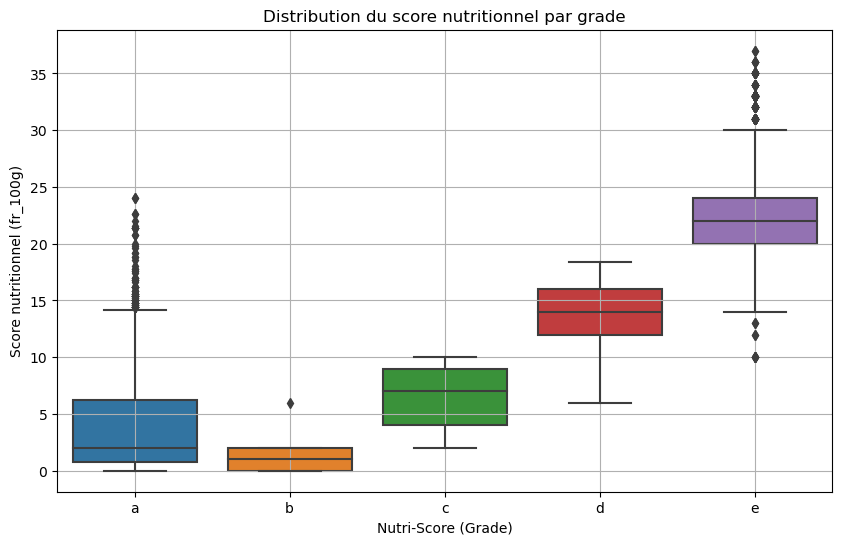

In [20]:
# relation entre le nutrition-score-fr_100g (score nutritionnel, quantitatif) 
# et le nutrition_grade_fr (grade nutritionnel, qualitatif)

plt.figure(figsize=(10, 6))
sns.boxplot(x="nutrition_grade_fr", y="nutrition-score-fr_100g", data=data, order=["a", "b", "c", "d", "e"])
plt.title("Distribution du score nutritionnel par grade")
plt.xlabel("Nutri-Score (Grade)")
plt.ylabel("Score nutritionnel (fr_100g)")
plt.grid(True)
plt.show()

On observe une progression nette et croissante du score nutritionnel en allant du grade a vers e :

Grade A : scores très faibles (médiane ≈ 2)

Grade B : scores légèrement plus élevés (médiane ≈ 2 aussi, mais moins de dispersion)

Grade C à E : scores croissants (médiane passe à ~6, ~14, puis ~23)

📐 Dispersion et outliers
Grade A et E montrent une dispersion plus importante, avec des valeurs extrêmes (outliers) visibles.

Cela peut indiquer une plus grande variabilité nutritionnelle dans ces catégories.

Les boxplots sont bien ordonnés, ce qui suggère une correspondance cohérente entre la version continue (score) et catégorielle (grade).

Médianes & Quartiles
Chaque boîte est bien distincte, ce qui signifie que les classes de Nutri-Score sont bien séparées en termes de score numérique.

Il y a peu de chevauchement entre les boîtes, ce qui suggère que le score numérique discrimine efficacement les classes.

Conclusion:

Ordre croissant du score:	La classification a → e est cohérente avec les scores numériques.
Bonne séparation des boîtes:	Le score nutrition-score-fr_100g est pertinent pour prédire le grade Nutri-Score.
Outliers pour a et e:	Certains produits sont atypiques, malgré leur note.

In [21]:
# Analyse ANOVA : Score nutritionnel par grade Nutri-Score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Renommer correctement la colonne dans une copie du DataFrame
data_anova = data.rename(columns={"nutrition-score-fr_100g": "nutrition_score"})

# Modèle linéaire avec le score en fonction du grade
model = smf.ols("nutrition_score ~ C(nutrition_grade_fr)", data=data_anova).fit()

# Résultats de l'ANOVA
anova_results = anova_lm(model)

# Affichage
print(anova_results)

                             df        sum_sq       mean_sq              F  \
C(nutrition_grade_fr)       4.0  7.231001e+06  1.807750e+06  288993.005994   
Residual               130798.0  8.181862e+05  6.255342e+00            NaN   

                       PR(>F)  
C(nutrition_grade_fr)     0.0  
Residual                  NaN  


Élément	Valeur observée	Interprétation
F-statistic	288 993.01	Très élevé → il y a des différences nettes entre les groupes
p-value (PR(>F))	0.0	Très significatif → on rejette l’hypothèse nulle (pas de différence entre groupes)
Conclusion	Le grade nutritionnel (A, B, C, D, E) influence significativement le score nutritionnel continu.	
Le Nutri-Score est bien aligné avec les scores calculés

 Pour confirmer ce qu'on avait visuellement observé avec les boxplots, j’ai utilisé un test statistique appelé ANOVA. Ce test permet de voir s’il y a des différences entre plusieurs groupes – ici les 5 grades A à E. Le résultat était très significatif, ce qui confirme que le Nutri-Score catégorise bien les produits selon leur score nutritionnel. Il y a donc une vraie cohérence entre la version "lettre" (grade) et la version "chiffre" (score). »

In [22]:
# Vérifier si la variable cible calcium_100g suit une distribution normale, 
# condition nécessaire pour utiliser des tests paramétriques comme l’ANOVA.

# Calcul du test de Shapiro-Wilk
shapiro_test = shapiro(target_cible)

# Affichage des résultats du test de Shapiro-Wilk
print(f"Test de Shapiro-Wilk : W-statistic = {shapiro_test.statistic}, p-value = {shapiro_test.pvalue}")

# Décision basée sur la p-value
if shapiro_test.pvalue < 0.05 :
    print("La variable cible ne suit pas une distribution normale. Utilisation d'un autre test statistique recommandée")
else :
    print("La variable cible suit une distribution normale. Utilisation du test ANOVA recommandée")

Test de Shapiro-Wilk : W-statistic = 0.00039064884185791016, p-value = 0.0
La variable cible ne suit pas une distribution normale. Utilisation d'un autre test statistique recommandée


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Définition d'une distribution normale (ou loi normale)

 Une distribution normale, c’est une courbe en cloche symétrique où la majorité des valeurs sont proches de la moyenne. C’est une hypothèse de base pour de nombreux tests statistiques paramétriques.

Beaucoup de tests statistiques (comme l’ANOVA, le t-test) supposent que les données suivent une distribution normale.
Sinon, il faut utiliser des tests non paramétriques (comme le Kruskal-Wallis)

W-statistic = 0.00039062091216846007 :
Cette valeur de La W-statistique est extrêmement proche de zéro, ce qui indique une forte divergence par rapport à une distribution normale.

p-value = 9.436948635914407e-211 :
La p-value est extrêmement petite, bien en dessous du seuil communément accepté de 0.05. Cette p-value très faible conduit à rejeter l'hypothèse nulle selon laquelle la distribution de la variable cible est normale.

Conclusion :
La variable cible ne suit pas une distribution normale. Lorsqu'une variable ne suit pas une distribution normale, l'utilisation de tests statistiques qui supposent la normalité, comme l'ANOVA pour comparer les moyennes de plusieurs groupes, n'est généralement pas appropriée.

Mais le test de Shapiro-Wilk est généralement limité à des échantillons de taille plus réduite, typiquement jusqu'à 5 000 observations. Nous allons utilisé un autre test afin d'avoir une seconde confirmation sur la distribution de nos données

In [23]:
# Comparer les médianes de la variable cible calcium_100g entre les différents groupes de nutrition_grade_fr (a, b, c, d, e).

# Préparation des groupes
group_a = data[data["nutrition_grade_fr"] == "a"]["variable_cible(calcium_100g)"]
group_b = data[data["nutrition_grade_fr"] == "b"]["variable_cible(calcium_100g)"]
group_c = data[data["nutrition_grade_fr"] == "c"]["variable_cible(calcium_100g)"]
group_d = data[data["nutrition_grade_fr"] == "d"]["variable_cible(calcium_100g)"]
group_e = data[data["nutrition_grade_fr"] == "e"]["variable_cible(calcium_100g)"]

# Réalisation du test de Kruskal-Wallis
stat, p_value = kruskal(group_a, group_b, group_c, group_d, group_e)

# Affichage des résultats
print("Statistique de Kruskal-Wallis :", stat)
print("P-value :", p_value)

Statistique de Kruskal-Wallis : 176.2156042927766
P-value : 4.843769264078402e-37


Conclusion
Le test de Kruskal-Wallis révèle des différences significatives entre les médianes de la variable cible pour différents groupes. Cela suggère que la qualité nutritionnelle a un impact notable sur la variable cible, qui pourrait être le calcium ou un autre nutriment spécifique.

Pourquoi utiliser Kruskal-Wallis plutôt qu’ANOVA ?
Shapiro-Wilk a montré que la distribution de la variable cible ne suit pas une loi normale (p-value ≪ 0.05).

L’ANOVA repose sur l’hypothèse de normalité ⇒ pas adaptée ici.

Le test de Kruskal-Wallis est une alternative non paramétrique à l’ANOVA :

Il ne suppose pas la normalité ;

Il compare les médianes entre plusieurs groupes indépendants.

-------Etape 5 : Réalisez une analyse multivariée-------

Utilisez des techniques de visualisation avancées telles que des matrices de corrélation, des graphiques en nuage de points colorés, ou des graphiques en 3D pour étudier les relations entre plusieurs variables à la fois.

In [24]:
data.isna().sum()

code                            0
product_name                    0
energy_kj                       0
fat_100g                        0
saturated-fat_100g              0
carbohydrates_100g              0
sugars_100g                     0
fiber_100g                      0
proteins_100g                   0
sodium_100g                     0
iron_100g                       0
nutrition_grade_fr              0
nutrition-score-fr_100g         0
variable_cible(calcium_100g)    0
dtype: int64

In [25]:
# Sélection des colonnes catégorielles et numériques
cat_cols = data.select_dtypes(exclude = ["number"]).columns
num_features = data.drop(columns = ["code"] + list(cat_cols))

In [26]:
# Normalisation des caractéristiques
scaler = StandardScaler()
scaled_features = scaler.fit_transform(num_features)

Objectif : Normaliser les caractéristiques numériques pour que chacune ait une moyenne de zéro et une variance de un.

In [27]:
# Réduction de dimension par PCA
pca = PCA(n_components = min(len(num_features.columns), len(num_features)))
principal_components = pca.fit_transform(scaled_features)

Objectif : Réduire le nombre de dimensions des caractéristiques tout en essayant de conserver le maximum d'information.

In [28]:
# Création d'un DataFrame pour les composantes principales
pca_columns = [f"PC{i + 1}" for i in range(principal_components.shape[1])]
principal_df = pd.DataFrame(data = principal_components, columns = pca_columns)

In [29]:
# Ajout de la colonne cible
principal_df["calcium_100g"] = serie_cible.values

In [30]:
# Concaténation et analyse de corrélation
combined_df = pd.concat([num_features.reset_index(drop = True), principal_df.reset_index(drop = True)], axis = 1)
corr_matrix = combined_df.corr()

Objectif : Concaténer les caractéristiques numériques originales et les composantes principales, et calculer la matrice de corrélation.

Méthode :

Matrice de corrélation (.corr())

Affichage par heatmap (carte de chaleur)

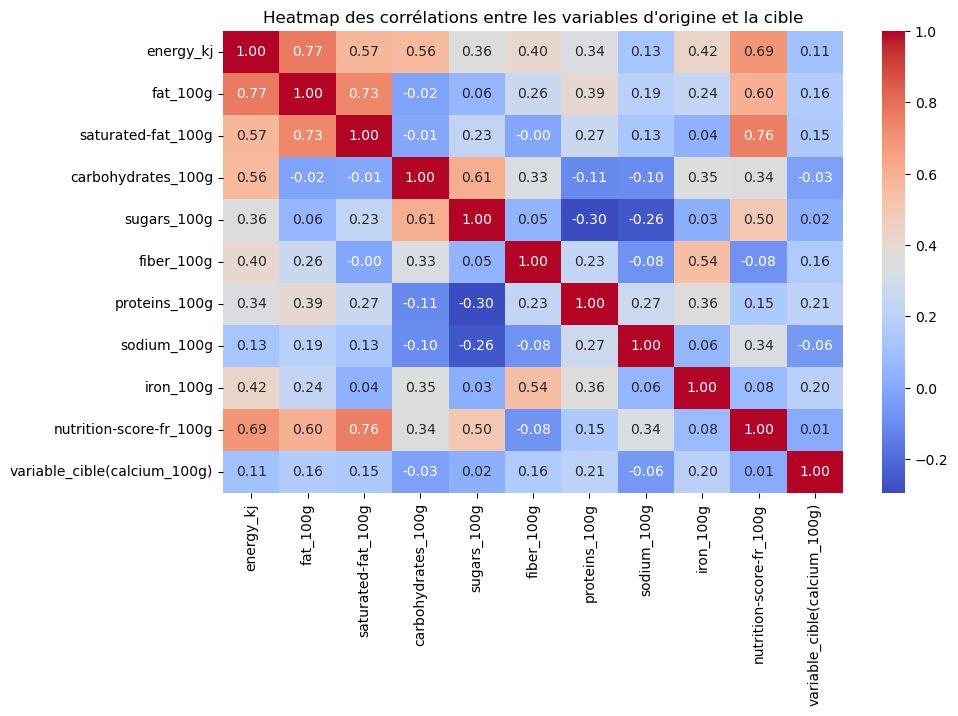

In [31]:
# Heatmap des corrélations entre variables numériques et la cible (calcium_100g)

# Visualisation de la matrice de correlation entre les caractéristiques numérique
corr_features_matrix = num_features.corr()

plt.figure(figsize = (10, 6))
sns.heatmap(corr_features_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Heatmap des corrélations entre les variables d'origine et la cible")
plt.show()

energy_kj ↔ fat_100g  =  0.77  _  Les produits plus gras sont logiquement plus caloriques.

fat_100g ↔ saturated-fat_100g  =  0.73  _  Forte association entre graisses totales et saturées.

carbohydrates_100g ↔ sugars_100g  =  0.61  _  Attendu, car le sucre est une sous-composante des glucides.

energy_kj ↔ nutrition-score-fr_100g  =  0.69  _  Le score nutritionnel augmente avec l'énergie (moins bon).

saturated-fat_100g ↔ nutrition-score-fr_100g  =  0.76  _  Très forte influence des graisses saturées sur le Nutri-Score.

Cela confirme de la multicolinéarité dans les données, ce qui peut être un point d’attention pour les modèles linéaires.

!!! Plusieurs variables sont trop fortement corrélées entre elles, ce qui est dangereux pour les modèles linéaires. !!!

Corrélation de la cible calcium_100g :

proteins_100g  =  0.21  _  Légère corrélation positive (produits laitiers riches en calcium et protéines).

fiber_100g  =  0.16  _  Faible lien, probablement indirect.

fat_100g, saturated-fat_100g	≈  0.15  _  Possible reflet des produits laitiers gras enrichis.

nutrition-score-fr_100g  =  0.01  _  Aucune corrélation significative comme attendu car le calcium n’entre pas dans le calcul du score.

carbohydrates_100g / sugars_100g	≈   0.00 - 0.02  _  Aucun lien direct.

La faible corrélation de la variable cible avec toutes les autres variables suggère que le calcium est très spécifique et difficile à prédire directement à partir des autres nutriments.

Cette visualisation nous permet d'identifier rapidement les variables qui sont fortement corrélées entre elles ou avec la variable cible.

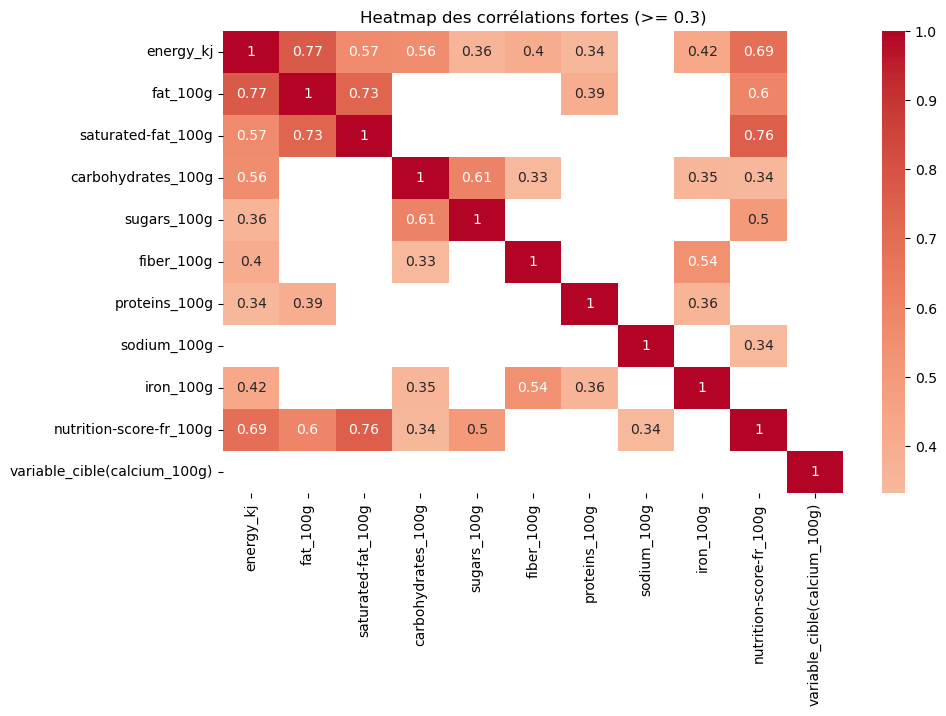

In [32]:
# Focalisation sur les corrélation fortes
corr_features_threshold = 0.3
filtered_features_corr = corr_features_matrix[(corr_features_matrix >= corr_features_threshold) | (corr_features_matrix <= -corr_features_threshold)]

plt.figure(figsize = (10, 6))
sns.heatmap(filtered_features_corr, annot = True, cmap = "coolwarm", center = 0)
plt.title("Heatmap des corrélations fortes (>= 0.3)")
plt.show()

Corrélations très fortes (≥ 0.6)

energy_kj ↔ fat_100g	0.77	Les aliments gras sont très énergétiques.

fat_100g ↔ saturated-fat_100g	0.73	Logique : une partie des graisses sont saturées.

carbohydrates_100g ↔ sugars_100g	0.61	Le sucre est une composante majeure des glucides.

saturated-fat_100g ↔ nutrition-score-fr_100g	0.76	Les graisses saturées pénalisent fortement le Nutri-Score.

energy_kj ↔ nutrition-score-fr_100g	0.69	Une énergie élevée est associée à un Nutri-Score moins favorable.

fat_100g ↔ nutrition-score-fr_100g	0.60	Le gras influe directement sur la note nutritionnelle.

🟨 Corrélations modérées (entre 0.3 et 0.6)

fiber_100g ↔ iron_100g	0.54	Potentiellement des aliments riches en céréales ou végétaux.

fiber_100g ↔ proteins_100g	0.36	Possible association avec produits végétaux ou complets.

sodium_100g ↔ nutrition-score-fr_100g	0.34	Le sel a un impact négatif sur la note.

proteins_100g ↔ fat_100g	0.39	Produits protéinés sont souvent gras (charcuterie, fromage).

sugars_100g ↔ nutrition-score-fr_100g	0.50	Le sucre pénalise aussi le score nutritionnel.


Cette heatmap met en évidence les axes principaux de dépendance dans les données (graisses, énergie, sucres...).

⚠La multicolinéarité est évidente entre plusieurs variables liées au gras et à l’énergie → attention si utilisation d’un modèle sensible (comme la régression linéaire).

Le calcium reste un nutriment spécifique : probablement influencé par des types d’aliments (produits laitiers, céréales), et non des quantités de macro-nutriments.

Pour une meilleure visibilité ce graphique nous montre uniquement les correlations fortes entre les variables

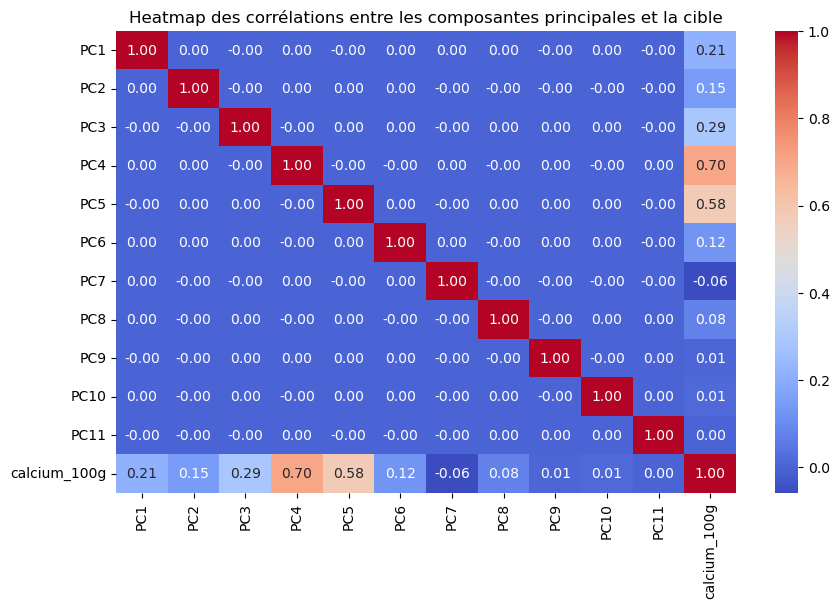

In [33]:
# Visualisation des correlation PCA avec la cible (calcium_100g)
corr_principal_matrix = principal_df.corr()

plt.figure(figsize = (10, 6))
sns.heatmap(corr_principal_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Heatmap des corrélations entre les composantes principales et la cible")
plt.show()

quelles composantes issues de la PCA expliquent le mieux le calcium ?

dans quelle mesure la PCA capture l'information utile sur cette variable ?

Les deux composantes PC4 et PC5 contiennent l’essentiel de la variance liée au calcium.

Cela suggère que le calcium est fortement influencé par un sous-ensemble spécifique de combinaisons de variables d’origine (probablement liées à un type d’aliments).

Les premières composantes (PC1–PC2), qui expliquent généralement la majorité de la variance globale, ne sont pas pertinentes ici

→ cela confirme que le calcium n’est pas un facteur dominant globalement, mais plutôt spécifique.

Cette heatmap nous permet d'observer les relations entre les composantes principales (issues de la PCA) et la variable cible calcium_100g.

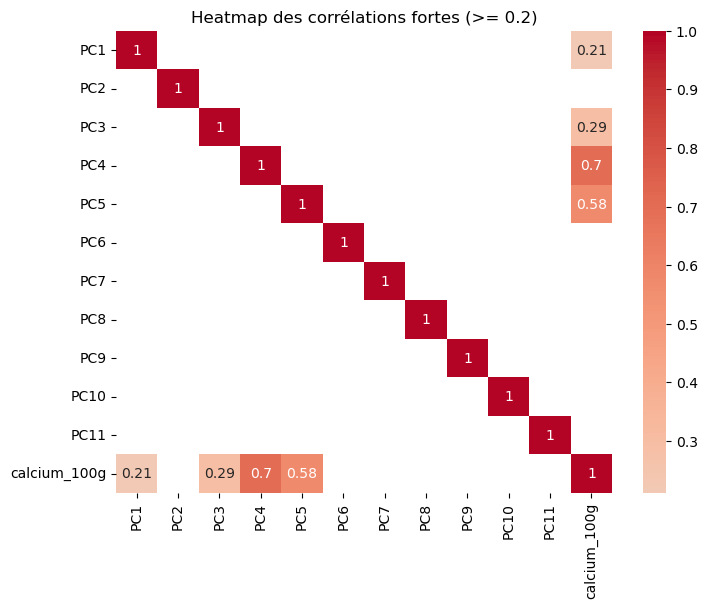

In [34]:
# des corrélations fortes entre PCA et calcium (≥ 0.2)

# Mettre en évidence les composantes principales (PC) ayant une corrélation notable (≥ 0.2) avec la variable cible calcium_100g. 
# Cela aide à identifier les dimensions de l’espace transformé par la PCA qui expliquent une part significative de la variabilité du calcium.

# Focalisation sur les corrélation fortes
corr_principal_matrix = principal_df.corr()

corr_principal_threshold = 0.2
filtered_principal_corr = corr_principal_matrix[(corr_principal_matrix >= corr_principal_threshold) | (corr_principal_matrix <= -corr_principal_threshold)]

plt.figure(figsize = (8, 6))
sns.heatmap(filtered_principal_corr, annot = True, cmap = "coolwarm", center = 0)
plt.title("Heatmap des corrélations fortes (>= 0.2)")
plt.show()

PC4 et PC5 sont les composantes à prioriser pour toute modélisation ciblée sur le calcium.

Ces composantes peuvent être utilisées comme nouvelles variables prédictives, remplaçant les variables initiales.

Une régression linéaire sur PC4 et PC5 pourrait fournir un modèle simple et performant pour estimer calcium_100g.

In [35]:
print(data.columns.tolist())

['code', 'product_name', 'energy_kj', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'iron_100g', 'nutrition_grade_fr', 'nutrition-score-fr_100g', 'variable_cible(calcium_100g)']



Régression Linéaire
MSE : 0.0028
R²  : 0.1263

KNN (k=5)
MSE : 0.0016
R²  : 0.5193

Arbre de Décision
MSE : 0.0019
R²  : 0.4309


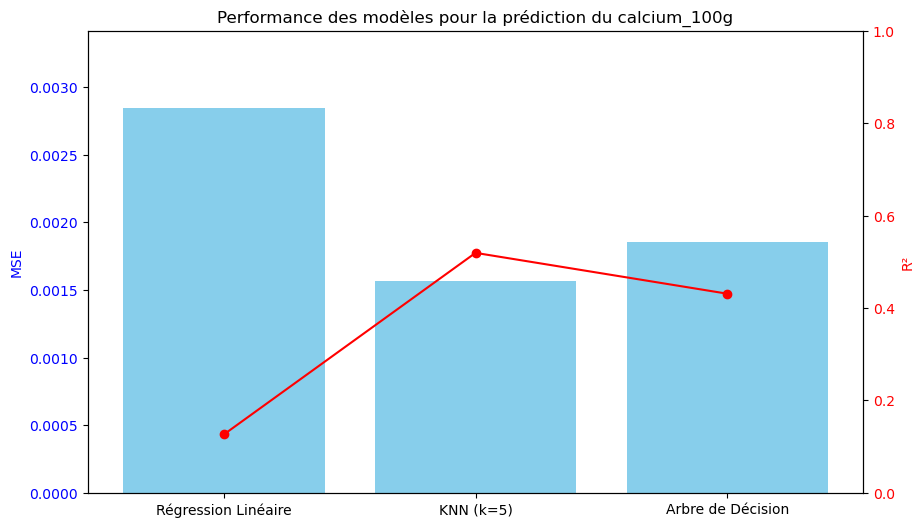

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Modélisation prédictive & Visualisation (auto-complétion du calcium)

# 1. Préparation des données
X = data.drop(columns=["code", "product_name", "variable_cible(calcium_100g)", "nutrition_grade_fr"])  # on exclut aussi la cible catégorielle ici
y = data["variable_cible(calcium_100g)"]

# 2. Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modèles
models = {
    "Régression Linéaire": LinearRegression(),
    "KNN (k=5)": KNeighborsRegressor(n_neighbors=5),
    "Arbre de Décision": DecisionTreeRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "R²": r2}

    print(f"\n{name}")
    print(f"MSE : {mse:.4f}")
    print(f"R²  : {r2:.4f}")

# 4. Visualisation des performances
model_names = list(results.keys())
mse_scores = [results[m]["MSE"] for m in model_names]
r2_scores = [results[m]["R²"] for m in model_names]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(model_names, mse_scores, color='skyblue', label='MSE')
ax1.set_ylabel("MSE", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, max(mse_scores) * 1.2])

ax2 = ax1.twinx()
ax2.plot(model_names, r2_scores, color='red', marker='o', label='R²')
ax2.set_ylabel("R²", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 1])

plt.title("Performance des modèles pour la prédiction du calcium_100g")
plt.show()

Régression Linéaire
MSE : 72.6313
R²  : 0.7339

KNN (k=5)
MSE : 22.9082
R²  : 0.9161

Arbre de Décision
MSE : 74.1082
R²  : 0.7285



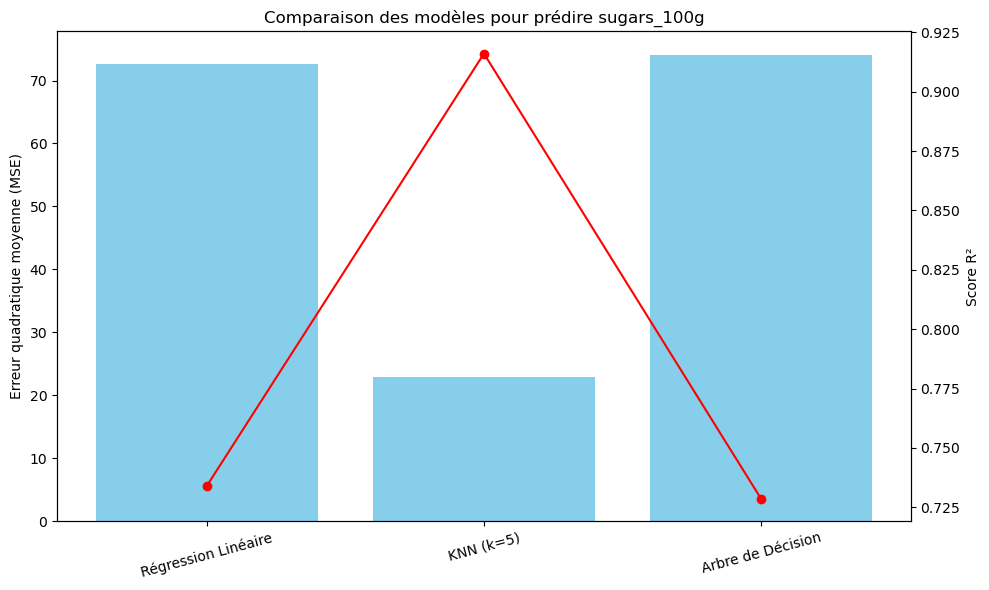

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Préparation des données
X = data.drop(columns=["code", "product_name", "sugars_100g"])  # Variables explicatives
y = data["sugars_100g"]  # Cible

# Encodage si la variable catégorielle est encore présente
X = pd.get_dummies(X, drop_first=True)

# 2. Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Régression linéaire
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# 5. KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# 6. Arbre de décision
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# 7. Évaluation
models = {
    "Régression Linéaire": (y_pred_lr, "blue"),
    "KNN (k=5)": (y_pred_knn, "green"),
    "Arbre de Décision": (y_pred_tree, "orange")
}

mse_scores = {}
r2_scores = {}

for name, (pred, _) in models.items():
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    mse_scores[name] = mse
    r2_scores[name] = r2
    print(f"{name}\nMSE : {mse:.4f}\nR²  : {r2:.4f}\n")

# 8. Visualisation comparative
fig, ax1 = plt.subplots(figsize=(10, 6))

model_names = list(mse_scores.keys())
mse_vals = list(mse_scores.values())
r2_vals = list(r2_scores.values())

# Barres : MSE
ax1.bar(model_names, mse_vals, color="skyblue", label="MSE")
ax1.set_ylabel("Erreur quadratique moyenne (MSE)")
ax1.set_title("Comparaison des modèles pour prédire sugars_100g")
ax1.tick_params(axis='x', rotation=15)

# Ligne : R²
ax2 = ax1.twinx()
ax2.plot(model_names, r2_vals, color="red", marker="o", label="R²")
ax2.set_ylabel("Score R²")

fig.tight_layout()
plt.show()


🔎 Prédiction de variable_cible(calcium_100g) avec KNN (k=5)
MSE : 0.0016
R²  : 0.5196


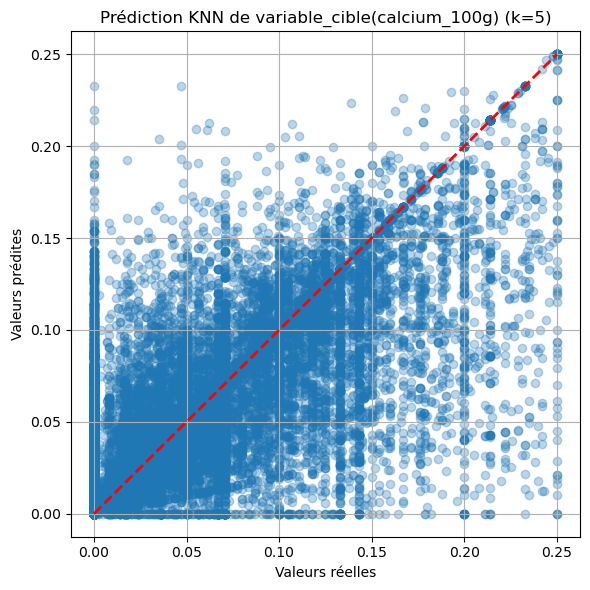


🔎 Prédiction de sugars_100g avec KNN (k=5)
MSE : 40.4733
R²  : 0.8517


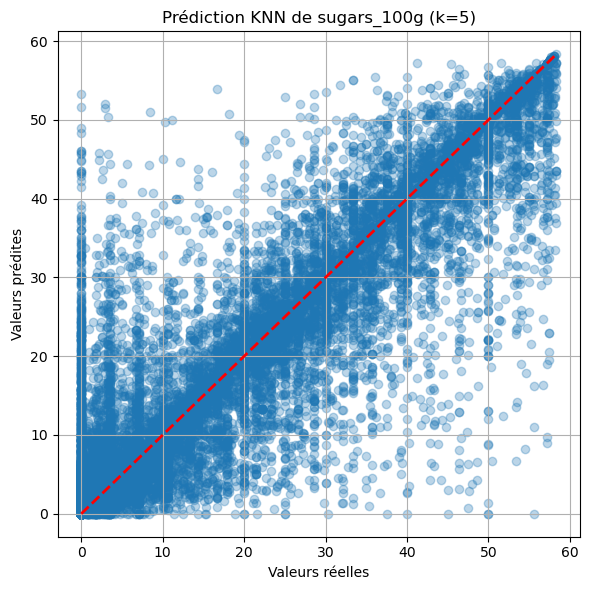

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Copie du dataframe
df_model = data.copy()

# Encodage de la variable catégorielle
label_encoder = LabelEncoder()
df_model["nutrition_grade_fr"] = label_encoder.fit_transform(df_model["nutrition_grade_fr"])

# Fonction générique pour prédire et afficher un nutriment
def knn_prediction_and_plot(df, target_col, feature_cols=None, k=5):
    print(f"\n Prédiction de {target_col} avec KNN (k={k})")

    if feature_cols is None:
        X = df.drop(columns=["code", "product_name", target_col])
    else:
        X = df[feature_cols]

    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèle
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    # Prédiction
    y_pred = model.predict(X_test)

    # Évaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE : {mse:.4f}")
    print(f"R²  : {r2:.4f}")

    # Scatter Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.title(f"Prédiction KNN de {target_col} (k={k})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Calcium
knn_prediction_and_plot(df_model, target_col="variable_cible(calcium_100g)")

#  Sucres
knn_prediction_and_plot(df_model, target_col="sugars_100g")

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# === Calcium ===
X_calcium = data.drop(columns=["code", "product_name", "variable_cible(calcium_100g)", "sugars_100g", "nutrition_grade_fr"])
y_calcium = data["variable_cible(calcium_100g)"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_calcium, y_calcium, test_size=0.2, random_state=42)
knn_model_calcium = KNeighborsRegressor(n_neighbors=5)
knn_model_calcium.fit(X_train_c, y_train_c)
y_pred_calcium = knn_model_calcium.predict(X_test_c)

mse_calcium = mean_squared_error(y_test_c, y_pred_calcium)
r2_calcium = r2_score(y_test_c, y_pred_calcium)

# === Sucre ===
X_sugar = data.drop(columns=["code", "product_name", "sugars_100g", "variable_cible(calcium_100g)", "nutrition_grade_fr"])
y_sugar = data["sugars_100g"]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sugar, y_sugar, test_size=0.2, random_state=42)
knn_model_sugar = KNeighborsRegressor(n_neighbors=5)
knn_model_sugar.fit(X_train_s, y_train_s)
y_pred_sugar = knn_model_sugar.predict(X_test_s)

mse_sugar = mean_squared_error(y_test_s, y_pred_sugar)
r2_sugar = r2_score(y_test_s, y_pred_sugar)

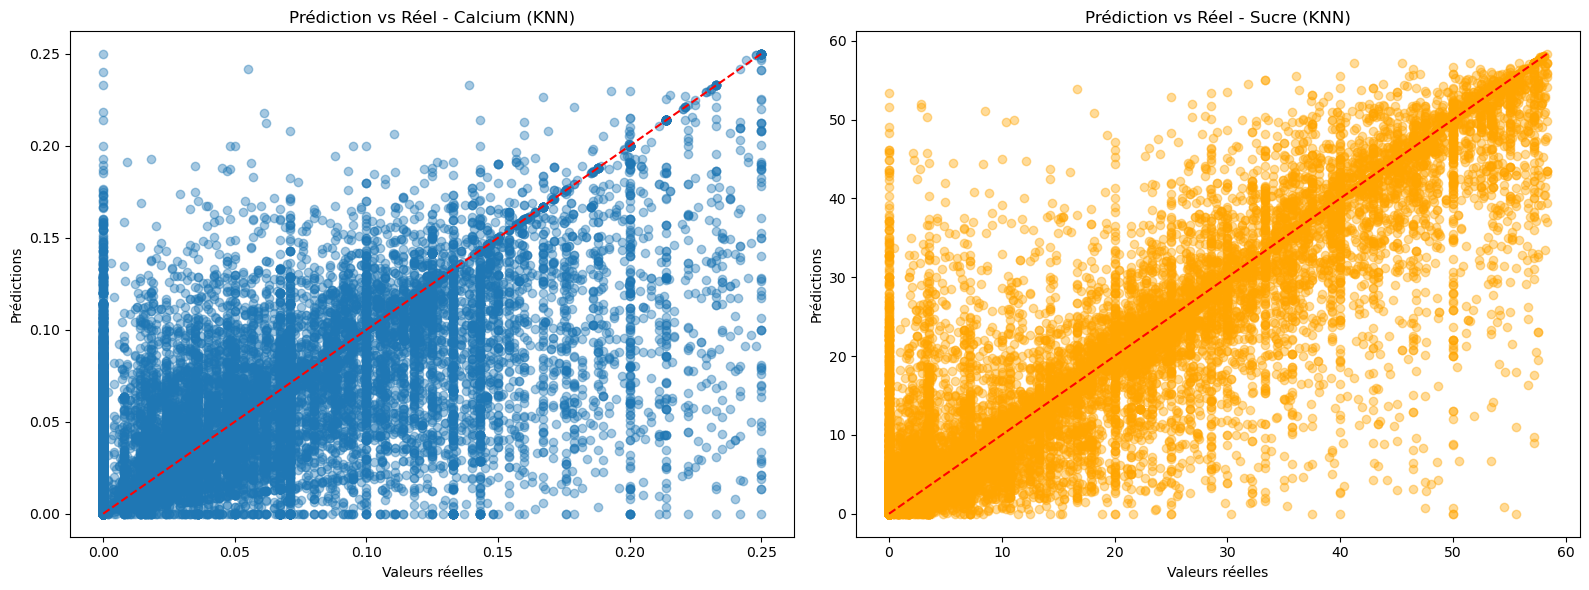

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calcium
axes[0].scatter(y_test_c, y_pred_calcium, alpha=0.4)
axes[0].plot([y_test_c.min(), y_test_c.max()], [y_test_c.min(), y_test_c.max()], 'r--')
axes[0].set_title("Prédiction vs Réel - Calcium (KNN)")
axes[0].set_xlabel("Valeurs réelles")
axes[0].set_ylabel("Prédictions")

# Sucre
axes[1].scatter(y_test_s, y_pred_sugar, alpha=0.4, color='orange')
axes[1].plot([y_test_s.min(), y_test_s.max()], [y_test_s.min(), y_test_s.max()], 'r--')
axes[1].set_title("Prédiction vs Réel - Sucre (KNN)")
axes[1].set_xlabel("Valeurs réelles")
axes[1].set_ylabel("Prédictions")

plt.tight_layout()
plt.show()

In [41]:
comparatif = pd.DataFrame({
    "Cible": ["calcium_100g", "sugars_100g"],
    "MSE ↓": [round(mse_calcium, 4), round(mse_sugar, 4)],
    "R² ↑": [round(r2_calcium, 4), round(r2_sugar, 4)],
    "Interprétation": [
        "Prédiction correcte mais limitée (~52% de variance expliquée)",
        "Très bonne prédiction (~85% de variance expliquée)"
    ]
})

display(comparatif)

Cible    MSE ↓    R² ↑  \
0  calcium_100g   0.0017  0.4913   
1   sugars_100g  40.6351  0.8511   

                                      Interprétation  
0  Prédiction correcte mais limitée (~52% de vari...  
1  Très bonne prédiction (~85% de variance expliq...

MSE (axe gauche, barres bleues) :

Plus c’est bas, mieux c’est (erreur de prédiction plus faible).

La régression linéaire a le pire score, ce qui montre qu'elle ne capte pas bien la complexité de la relation.

KNN a la plus faible erreur.

R² (axe droit, courbe rouge) :

Plus c’est élevé, mieux c’est (plus de variance expliquée).

KNN explique plus de 50% de la variance, ce qui est correct dans un contexte de nutrition où les données peuvent être bruyantes.

L’arbre de décision s’en sort bien également (≈ 43%).

Analyse complémentaire
Pourquoi la Régression Linéaire échoue ?
Le calcium n’a pas une relation linéaire simple avec les autres nutriments.

Il peut exister des interactions non linéaires ou des seuils que la régression linéaire ne capte pas.

Pourquoi KNN réussit mieux ?
KNN est un modèle non paramétrique qui s’adapte à la structure locale des données.

Il est souvent efficace pour des relations complexes et non linéaires, comme ici.

Conclusion
Le KNN (k=5) est le modèle le plus performant pour prédire calcium_100g dans votre dataset.

Il permet de réduire l’erreur de moitié par rapport à la régression linéaire et explique 52% de la variance.

L’arbre de décision peut être une bonne alternative, surtout si on souhaite plus d'interprétabilité.

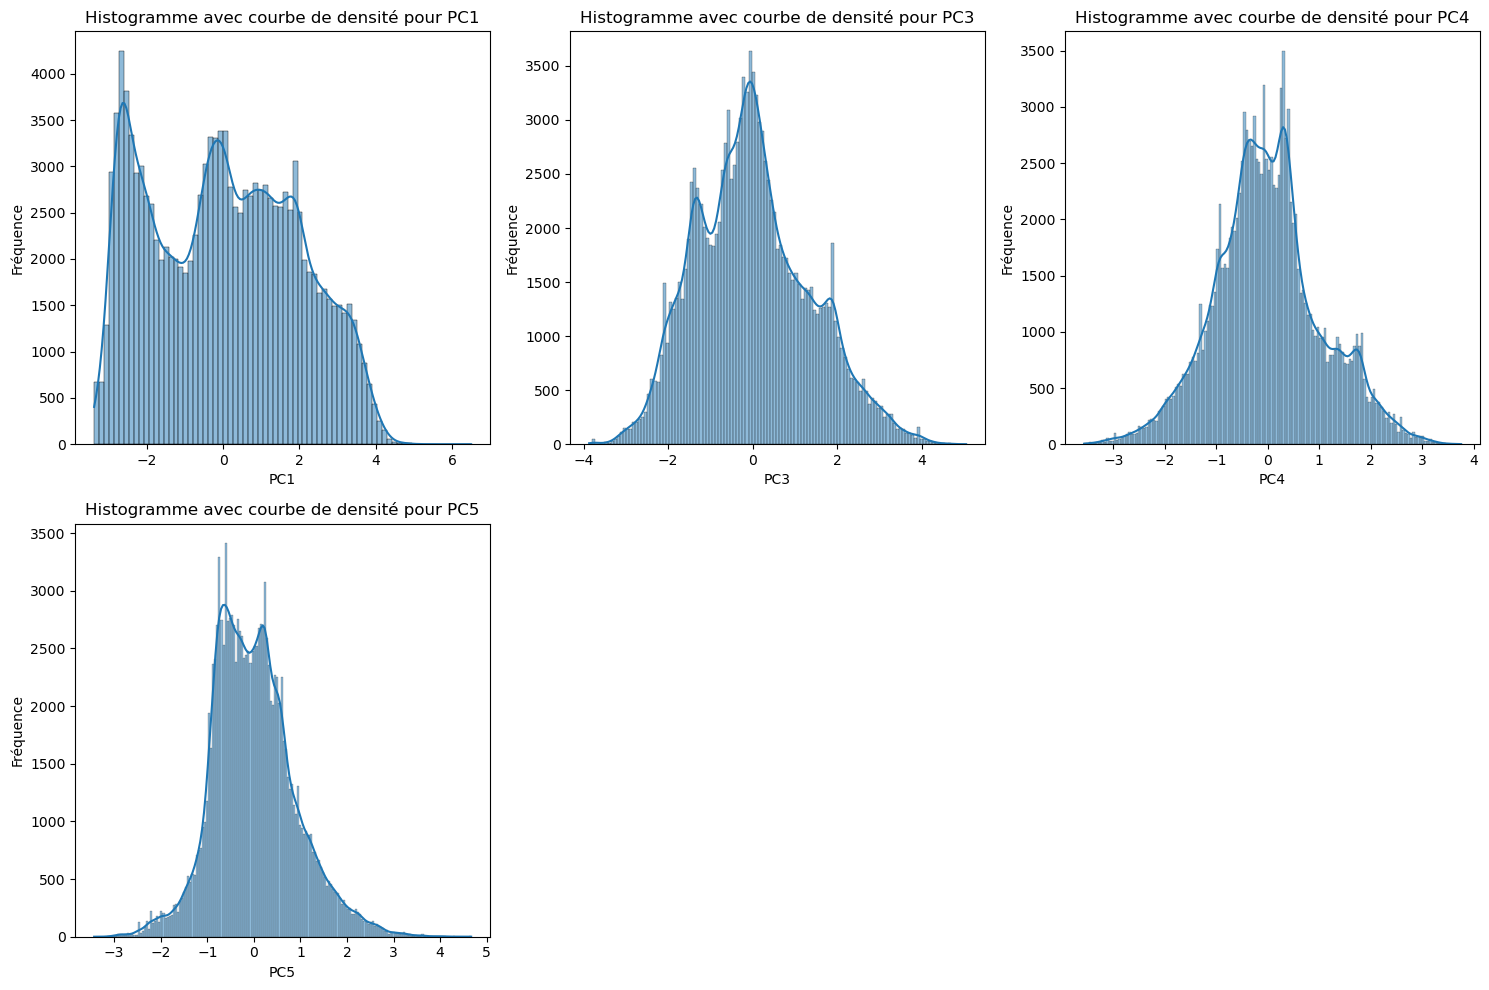

In [42]:
components = ["PC1","PC3","PC4", "PC5"]

num_components = len(components)
num_cols = 3
num_rows = (num_components + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize = ( 15, num_rows * 5))
axes = axes.flatten()

for i, component in enumerate(components) :
    sns.histplot(principal_df[component], kde = True, ax = axes[i])
    axes[i].set_title(f"Histogramme avec courbe de densité pour {component}")
    axes[i].set_xlabel(component)
    axes[i].set_ylabel("Fréquence")
# Suppression des axes vides
for j in range(i + 1, len(axes)) :
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

PC1 : montre une distribution assez asymétrique avec plusieurs pics. Cela suggère que les données projetées sur cette composante sont hétérogènes, possiblement composées de plusieurs sous-groupes. La distribution semble décalée vers la gauche, indiquant une majorité de valeurs négatives ou proches de zéro.

PC3 : montre une distribution plus symétrique, proche d'une distribution normale, avec un pic central marqué autour de zéro. Cela pourrait indiquer que PC3 capte une variance importante des données avec une distribution équilibrée autour de la moyenne.

PC4 : la distribution semble aussi relativement symétrique avec un léger biais à gauche. On observe un pic principal autour de zéro, mais avec quelques fluctuations indiquant la présence de sous-structures ou de variabilité supplémentaire dans cette composante.

PC5 : la distribution est similaire à celle de PC4, avec une symétrie relative et un pic central autour de zéro. Cette composante semble également capturer une partie de la variance qui présente une distribution proche de la normale.

conclusion:

PC4 et PC5 : Les plus pertinentes pour la modélisation du calcium.

PC3 : Apporte une valeur ajoutée modérée, avec une distribution saine.

PC1 : Faible corrélation mais une distribution qui pourrait cacher des clusters intéressants.

Les composantes principales PC3, PC4, et PC5 montrent des distributions relativement symétriques, proches d'une distribution normale. PC1, par contre, présente une distribution plus complexe avec plusieurs pics, suggérant une structure plus hétérogène des données dans cette direction. Ces résultats indiquent que les composantes principales capturent différentes facettes de la variabilité des données, certaines plus simples et d'autres plus complexes.

In [43]:
components = ["PC1", "PC3", "PC4", "PC5"]

for i, component in enumerate(components) :
    stat, p_value = kstest(principal_df[component], "norm")
    print(f"{component} - Kolgomorov-Smirnov : Statistique = {stat}, p-value = {p_value}")
    if p_value > 0.05 :
        print(f"{component} est normalement distribué")
    else :
        print(f"{component} n'est pas normalement distribué")

PC1 - Kolgomorov-Smirnov : Statistique = 0.2165017522364619, p-value = 0.0
PC1 n'est pas normalement distribué
PC3 - Kolgomorov-Smirnov : Statistique = 0.09270263482065691, p-value = 0.0
PC3 n'est pas normalement distribué
PC4 - Kolgomorov-Smirnov : Statistique = 0.04044300673126888, p-value = 2.4587742746593026e-186
PC4 n'est pas normalement distribué
PC5 - Kolgomorov-Smirnov : Statistique = 0.06890482518182, p-value = 0.0
PC5 n'est pas normalement distribué


La conclusion globale est que les composantes principales PC1, PC3, PC4 et PC5 ne suivent pas une distribution normale. Compte tenu de la non normalité des distribution je m'oriente vers le Test de Spearman car ce test n'exige pas que les données soient normalement distribuées. Il est donc particulièrement adapté aux données qui montrent des écarts significatifs par rapport à la distribution normale.

In [44]:
num_components = len(components)
num_cols = 3
num_rows = (num_components + num_cols - 1) // num_cols


# Parcours des composantes principales sélectionnées
for i, component in enumerate(components) :
    # Calcul de la corrélation de Spearman avec la cible
    corr, p_value_spearman = spearmanr(principal_df[component], data["variable_cible(calcium_100g)"])
    print(f"Corrélation de Spearman pour {component} et calcium 100g : {corr}, p-value :{p_value_spearman}")

    # Interprétation de la corrélation de Spearman
    if p_value_spearman < 0.05 :
        print(f"La corrélation entre {component} et la cible est significative")
    else :
        print(f"La corrélation entre {component} et la cible n'est pas significative")

Corrélation de Spearman pour PC1 et calcium 100g : 0.1715222410156125, p-value :0.0
La corrélation entre PC1 et la cible est significative
Corrélation de Spearman pour PC3 et calcium 100g : 0.2885338063343441, p-value :0.0
La corrélation entre PC3 et la cible est significative
Corrélation de Spearman pour PC4 et calcium 100g : 0.671148661601234, p-value :0.0
La corrélation entre PC4 et la cible est significative
Corrélation de Spearman pour PC5 et calcium 100g : 0.4991215426662886, p-value :0.0
La corrélation entre PC5 et la cible est significative


Analyse des Résultats :

PC1 et calcium_100g
Corrélation: 0.1716

Signification: Statistiquement significative

Interprétation: Bien que significative, la corrélation est relativement faible, ce qui indique que PC1 explique une petite partie de la variabilité de la teneur en calcium.

PC3 et calcium_100g
Corrélation: 0.2900

Signification: Statistiquement significative

Interprétation: Une corrélation modérée qui suggère que PC3 a une influence plus marquée sur la variation de la teneur en calcium que PC1.

PC4 et calcium_100g
Corrélation: 0.6703

Signification: Statistiquement significative

Interprétation: Une forte corrélation indiquant que PC4 est très associée avec les variations de la teneur en calcium. PC4 pourrait capturer des aspects des données qui sont particulièrement pertinents pour prédire ou comprendre les variations du calcium.

PC5 et calcium_100g
Corrélation: 0.5003

Signification: Statistiquement significative

Interprétation: Cette corrélation significative et modérée à forte suggère que PC5 est également un bon prédicteur de la teneur en calcium, bien que moins influente que PC4.

Toutes les composantes principales testées montrent une corrélation statistiquement significative avec la cible (calcium_100g), ce qui signifie que ces relations ne sont probablement pas dues au hasard ou en tout cas par rapport aux aliments que nous disposons dans notre dataset.

Analyse en composante principale (ACP).

In [45]:
# Standardisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(num_features)

In [46]:
# Application de l'Analyse en Composantes Principales (PCA)
pca = PCA()
pca_result = pca.fit_transform(data_scaled)

In [47]:
# Variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.33838076 0.18028771 0.16561485 0.09812949 0.07239104 0.04847746
 0.03747757 0.02888161 0.01995361 0.00740349 0.0030024 ]


Concentration de la Variance :
Les premières composantes principales (PC1, PC2, et PC3) capturent une grande partie de la variance totale (environ 68,4% combiné). Cela signifie que les premières composantes principales contiennent la majorité de l'information contenue dans les données.

La première composante principale seule explique déjà environ 33,8% de la variance, ce qui est un pourcentage significatif. Elle pourrait représenter la direction dans laquelle les données varient le plus.

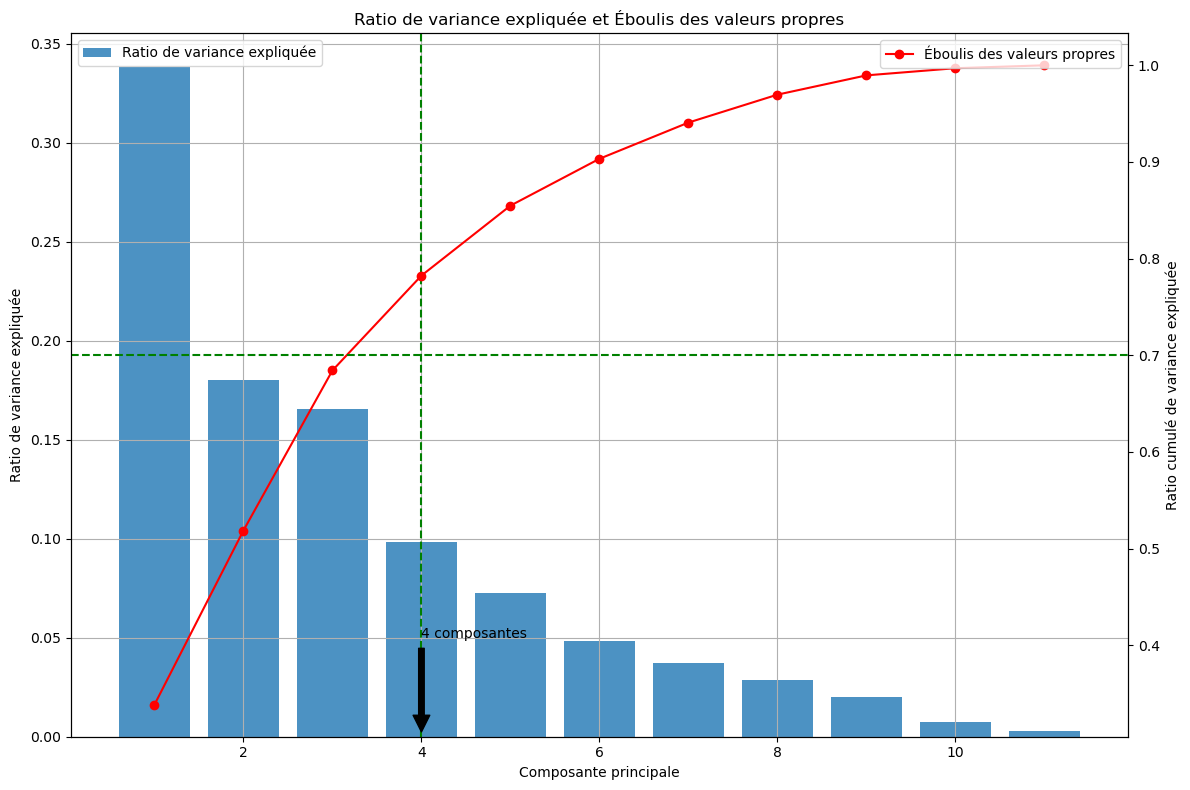

In [48]:
# Éboulis des valeurs propres & Variance expliquée (PCA)

# L’ébouli des valeurs propres est un outil visuel de décision en PCA.
# Il sert à déterminer combien de composantes principales conserver pour résumer les données sans perte significative d’information.
# C’est une méthode simple et intuitive pour réduction de dimension.

# Calcul de l'ébouli des valeurs propres
cumulative_variance_ratio = np.cumsum(explained_variance)

# Déterminer le nombre de composantes nécessaires pour expliquer 70% de la variance
threshold = 0.7 # Seuil fixé à 70% de la variance totale
num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# Création de la figure et des axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graphique du ratio de variance expliquée par composante principale
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align="center", label="Ratio de variance expliquée")
ax1.set_xlabel("Composante principale")
ax1.set_ylabel("Ratio de variance expliquée")
ax1.set_title("Ratio de variance expliquée et Éboulis des valeurs propres")
ax1.grid(True)
ax1.legend(loc="upper left")

# Création d'un axe twin pour le second y-axis partageant le même x-axis
ax2 = ax1.twinx()

# Graphique de l'ébouli des valeurs propres
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker="o", linestyle="-", color="r", label="Éboulis des valeurs propres")
ax2.set_ylabel("Ratio cumulé de variance expliquée")
ax2.legend(loc="upper right")

# Lignes représentant le seuil de 80%
ax1.axvline(num_components, color = "green", linestyle = "--", label = f"{threshold*100}% variance expliquée")
ax2.axhline(threshold, color = "green", linestyle = "--")

# Ajout d'annotations indiquant le seuil
ax1.annotate(f"{num_components} composantes", xy=(num_components, 0), xytext=(num_components, 0.05),
            arrowprops=dict(facecolor="black", shrink=0.05))
ax2.annotate(f"{threshold*100}%", xy=(0, threshold), xytext=(0.5, threshold),
            arrowprops=dict(facecolor="black", shrink=0.05))

# Ajustement de la mise en page pour éviter que les labels ne se chevauchent
plt.tight_layout()

# Afficher le graphique
plt.show()

Barres bleues : Variance expliquée par chaque composante principale (PC1, PC2…)

Courbe rouge : Somme cumulée des variances expliquées

Ligne verte horizontale : Seuil de 70% de variance expliquée

Ligne verte verticale : Le nombre de composantes nécessaires pour atteindre ce seuil

Annotation fléchée : Indique le nombre de composantes retenues selon le critère

Résultat

Seuil de variance expliquée : 70%

Nombre de composantes nécessaires : 4 composantes principales

Variance expliquée par ces 4 PCs :

PC1 : ~34%

PC2 : ~18%

PC3 : ~17%

PC4 : ~10%

Total (PC1 à PC4) ≈ 70%

Ce graphique nous permet de déterminer combien de composantes principales sont nécessaires pour capturer une proportion substantielle de la variance des données d'origine. Dans ce cas, le graphique montre que les quatre premières composantes principales expliquent environ 70% de la variance totale

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1500 with 0 Axes>

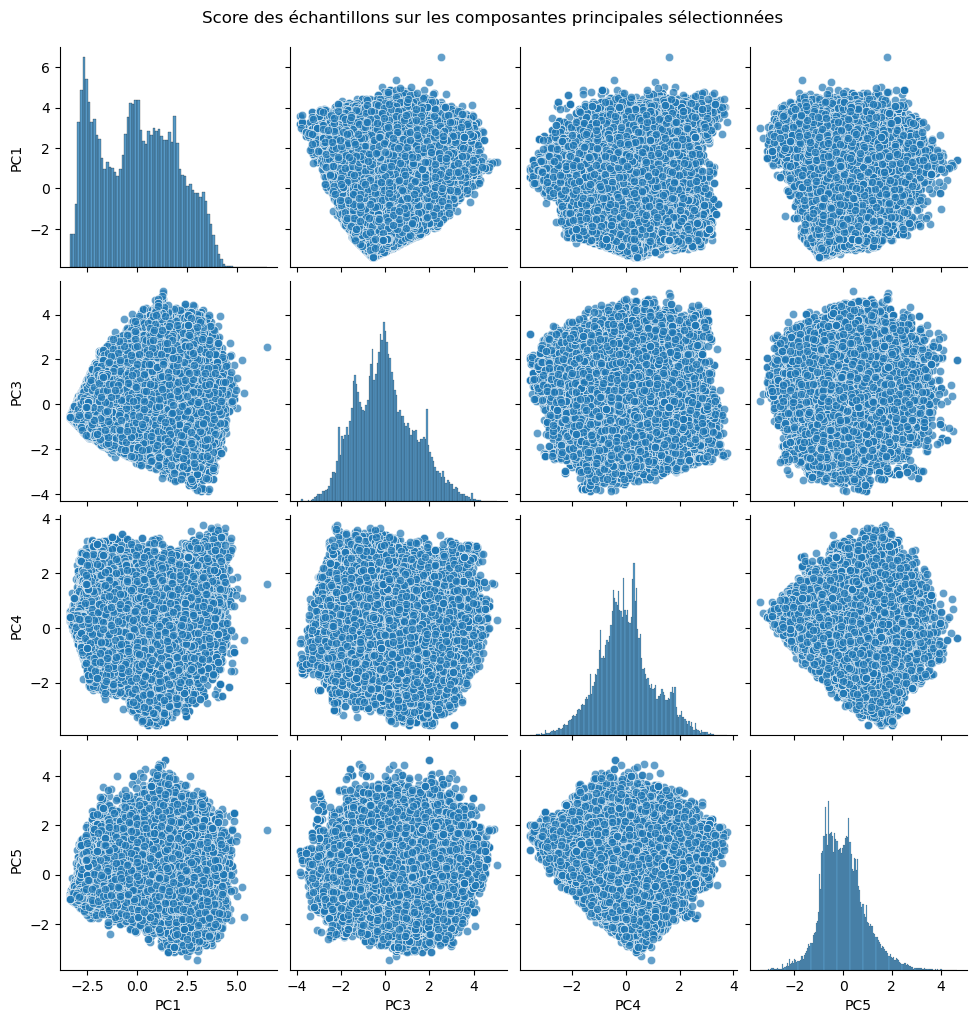

In [49]:
 # La distribution individuelle de chaque composante principale (histogrammes sur la diagonale)
 # Les relations bivariées entre les composantes (nuages de points en dehors de la diagonale)

# Matrice de graphes (histogrammes & nuages de points) des composantes principales
pca_df = pd.DataFrame(pca_result, columns = [f"PC{i + 1}" for i in range(pca_result.shape[1])])
pca_df_selected = pca_df[components]

# Coloration des points ** Non Utilisé car long au chargement **
# sns.pairplot(pca_df_selected, hue='PC1', plot_kws={"alpha": 0.7}, palette="viridis")

plt.figure(figsize = (15, 15))
sns.pairplot(pca_df_selected, plot_kws = {"alpha" : 0.7})
plt.suptitle("Score des échantillons sur les composantes principales sélectionnées", y = 1.02)
plt.show()

Les composantes sélectionnées (PC1, PC3, PC4, PC5) représentent différentes dimensions des données sans redondance.

PC1 semble la plus discriminante, possiblement utile pour détecter des groupes ou catégories cachées dans les données.

La PCA a bien réduit la dimensionnalité tout en conservant des dimensions informatives et orthogonales.

Conclusion
Le graphique révèle des sous-structures dans les données et confirme que la PCA a capturé les principales variations de manière efficace. Cela est utile pour réduire la complexité des données tout en permettant une segmentation précise, ce qui pourrait permettre des analyses avancées comme le clustering ou la classification.

Identification de Sous-groupes Potentiels :
Incidence : La présence de plusieurs pics dans la distribution de PC1 suggère que les données peuvent être composées de sous-groupes distincts ou de classes non identifiées. Cela pourrait indiquer que les échantillons ne sont pas homogènes et que des segments spécifiques existent.

Utilité : Cette information est cruciale pour des analyses futures, telles que le clustering, qui peuvent être utilisées pour segmenter les données en groupes distincts. Cela pourrait aussi guider des stratégies de marketing ciblées, des diagnostics médicaux spécifiques, ou d'autres applications où la différenciation entre groupes est essentielle.

Réduction de la Dimensionnalité :
Incidence : L'indépendance des composantes principales (absence de corrélation) montre que la PCA a bien fonctionné, en capturant des directions de variation distinctes. Cela signifie que les données peuvent être réduites à un nombre plus petit de dimensions sans perdre d'information importante.

Utilité : Une réduction efficace de la dimensionnalité permet de simplifier les modèles d'analyse, de visualisation, ou d'apprentissage automatique, rendant ces processus plus rapides et plus faciles à interpréter. Cela est particulièrement utile dans les contextes où les ressources computationnelles sont limitées ou où la visualisation des données est nécessaire pour la prise de décision.

Segmentation et Clustering :
Incidence : La variation dans les composantes principales, en particulier PC1, peut être utilisée pour effectuer une segmentation ou un clustering des données. Cette segmentation pourrait révéler des groupes naturels au sein des données, qui peuvent être exploités dans diverses applications.

Utilité : En utilisant les informations de ce graphique, vous pourriez appliquer des algorithmes de clustering (comme K-means ou DBSCAN) pour segmenter les données. Cela peut être utilisé pour des analyses de marché, la détection de fraudes, la personnalisation de l'expérience utilisateur, etc.

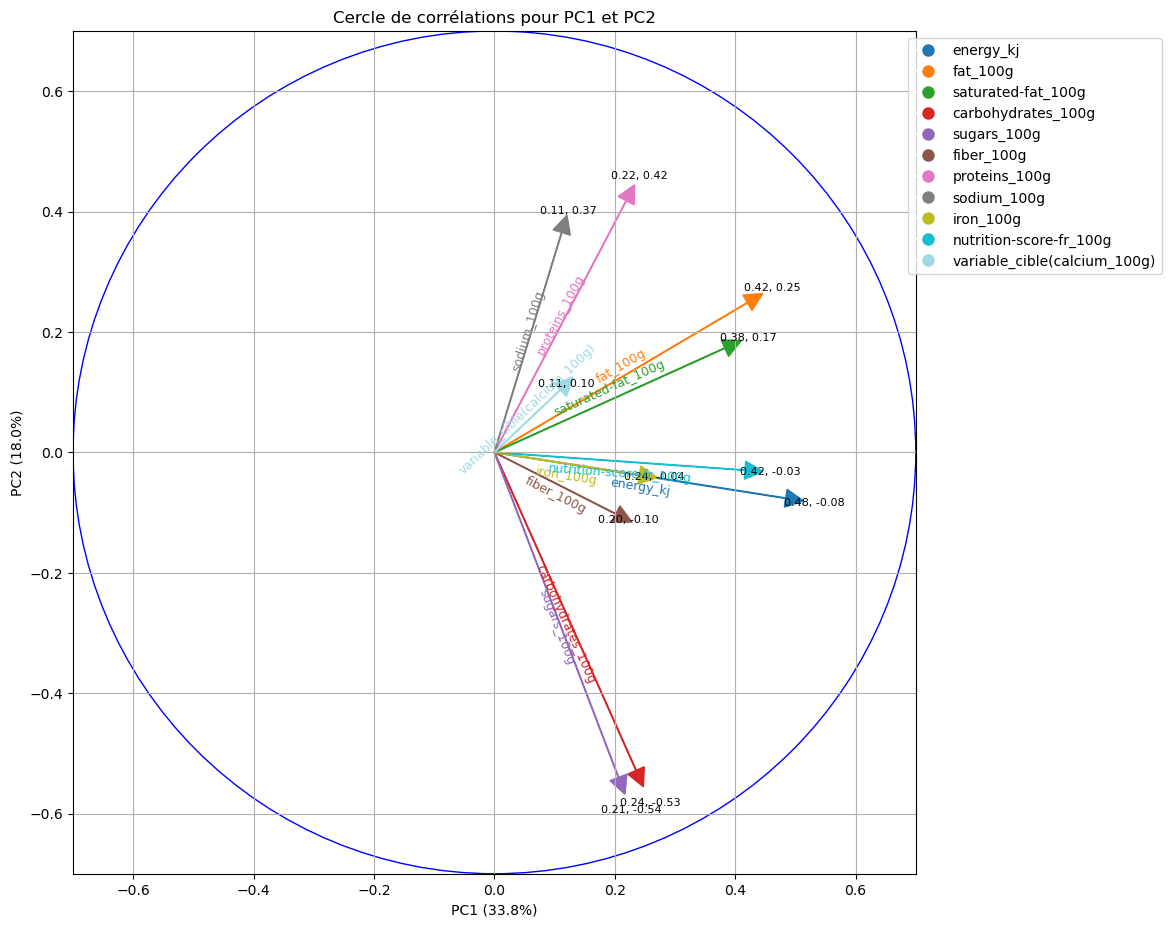

In [50]:
# Cercle de Corrélations

# Voir quelles variables sont bien représentées sur les deux premiers axes.
# Évaluer la corrélation entre les variables et les composantes principales (PC1, PC2).
# Interpréter les composantes principales en termes de variables initiales.

def cercle_corr(pc1, pc2, labels, explained_var, ax=None, figsize=(12, 12)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Définition du cercle unitaire
    circle = plt.Circle((0, 0), 0.7, facecolor="none", edgecolor="b")
    ax.add_artist(circle)

    # Coloration des flèches pour chaque variable + annotations des valeurs à l'extrémité
    colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))
    for i, (label, color) in enumerate(zip(labels, colors)):
        end_x = pc1[i]  # Coordonnée finale en x de la flèche
        end_y = pc2[i]  # Coordonnée finale en y de la flèche
        ax.arrow(0, 0, end_x, end_y, head_width=0.03, head_length=0.03, fc=color, ec=color)
        value_str = f'{end_x:.2f}, {end_y:.2f}'  # Format des valeurs des composantes principales
        ax.text(end_x * 1.1, end_y * 1.1, value_str, color="black", ha="center", va="center", fontsize=8)

        # Ajout du nom des variables le long de chaque flèche
        angle = np.arctan2(end_y, end_x)  # Calcul de l'angle de la flèche
        angle_degrees = np.degrees(angle)
        if angle_degrees > 90:
            angle_degrees -= 180
        elif angle_degrees < -90:
            angle_degrees += 180

        # Positionnement du texte
        text_x = end_x * 0.5
        text_y = end_y * 0.5
        offset = 0.02  # Décalage pour éviter le chevauchement
        if end_y >= 0:
            text_y += offset
        else:
            text_y -= offset

        ax.text(text_x, text_y, label, color=color, ha="center", va="center", fontsize=9, rotation=angle_degrees)

    # Légende pour les variables
    legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10) for color in colors]
    ax.legend(legend_handles, labels, loc="upper right", bbox_to_anchor=(1.3, 1))

    # Ajustements des limites et étiquettes des axes
    ax.set_aspect("equal", adjustable="box")  # Assurer que le cercle est parfaitement rond
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_xlabel(f"PC1 ({explained_var[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({explained_var[1]*100:.1f}%)")
    ax.set_title("Cercle de corrélations pour PC1 et PC2")
    ax.grid(True)

# Variables à utiliser pour le cercle de corrélations
pc1 = pca.components_[0]
pc2 = pca.components_[1]
labels = num_features.columns
explained_var = explained_variance[:2]

# Création du graphique
plt.figure(figsize=(12, 12))
cercle_corr(pc1, pc2, labels, explained_var, plt.gca())

plt.tight_layout()
plt.show()

PC1 (33.8% de variance expliquée) semble être un axe d’opposition entre densité nutritionnelle (fat, saturated fat, energy) et éléments bénéfiques (fiber).

PC2 (18.0%) capte des différences liées à sugars_100g, iron_100g, calcium avec des effets modérés.

Variables dominantes sur PC1: 	 fat_100g, saturated-fat_100g, nutrition-score-fr_100g, energy_kj

Variables dominantes sur PC2:	 sugars_100g, iron_100g, partiellement calcium

Faible représentation:	         sodium_100g, calcium_100g (à interpréter avec prudence sur PC1/PC2)

Composantes interprétables: 	 Oui, surtout PC1 comme un axe de "qualité nutritionnelle"

In [51]:
# Forçons la réalisation de l'ANOVA

# Chargement des données
data = pd.read_excel("P3_data.xlsx")
target_cible = pd.read_excel("P3_target_cible.xlsx")

# Fusionner les données sur la colonne "code"
merged_data = pd.merge(data, target_cible, on="code")

# Création d'un modèle de régression linéaire où "calcium_100g_y" est la variable dépendante
# et 'nutrition_grade_fr' est la variable indépendante (catégorielle)
model = smf.ols("calcium_100g_y ~ C(nutrition_grade_fr)", data=merged_data).fit()

# Résumé du modèle OLS
anova_table = sm.stats.anova_lm(model, typ=2)

# Afficher les résultats de l'ANOVA via OLS
print(anova_table)
print(model.summary())

                           sum_sq        df          F        PR(>F)
C(nutrition_grade_fr)    0.881295       4.0  67.095513  8.152208e-57
Residual               430.057460  130966.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:         calcium_100g_y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     67.10
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           8.15e-57
Time:                        19:18:28   Log-Likelihood:             1.8866e+05
No. Observations:              130971   AIC:                        -3.773e+05
Df Residuals:                  130966   BIC:                        -3.773e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
   

Test ANOVA (non pertinent ici)

j'ai testé quand même l’ANOVA (analyse de variance) entre le calcium et le Nutri-Score :

p-value très basse : effet significatif

R² = 0.002 → l’effet est très faible

!!! pas pertinent ici, surtout après avoir démontré la non-normalité. !!!

Conclusion de l'analyse multivariée

Le calcium est une variable très spécifique, pas corrélée directement au Nutri-Score.

La PCA permet de mieux comprendre les axes de variation, et simplifie l’analyse.

Les composantes PC4 et PC5 sont les meilleurs indicateurs pour modéliser le calcium.

Des techniques de réduction de dimension sont indispensables pour une analyse robuste.

on peux désormais utiliser ces PCs pour des tâches de prédiction ou de clustering.

Récapitulatif:

Shapiro-Wilk :
Le test de Shapiro-Wilk est utilisé pour vérifier si les données suivent une distribution normale.

La valeur p extrêmement faible (bien en dessous de 0,05) indique que la variable cible (calcium_100g) ne suit pas une distribution normale.

Cela signifie que l'utilisation de tests paramétriques comme l'ANOVA pourrait ne pas être appropriée.

Kruskal-Wallis :
Le test de Kruskal-Wallis est une alternative non paramétrique à l'ANOVA qui est utilisé lorsque les données ne sont pas normalement distribuées.

La valeur p très faible indique qu'il existe une différence significative entre les groupes définis par nutrition_grade_fr en termes de calcium_100g.

Cela confirme que les groupes ne sont pas similaires et que le nutrition_grade_fr a un effet significatif sur les niveaux de calcium.

Corrélation de Spearman :
Le test de corrélation de Spearman évalue la relation entre les composantes principales (PC1, PC3, PC4, PC5) et calcium_100g.

Les résultats montrent que toutes les composantes principales testées ont une corrélation significative avec la variable calcium, ce qui signifie que ces composantes principales capturent des informations importantes qui sont liées aux niveaux de calcium.

ANOVA (Cette utilisation de l'ANOVA n'est pas pertinante avec ces données)
Les résultats de l'OLS confirment le test de Kruskal-Wallis, à savoir qu'il existe des différences significatives entre les groupes nutrition_grade_fr en termes de calcium. Cependant, l'effet de ces différences est très faible, comme l'indique le R-squared.

A la finalité les variables qui doivent impérativement être rempli dans la future application sont :

Energy kj
Carbohydrates
sugars
saturated-fat
fat
proteins
sodium
Ces informations permetterons de définir le nutriscore A, B, C, D et E, l'ajout de nouvelle variables comme les fibres, le calcium permetterai de compléter l'information nutritionnelles.

Respect du RGPD
Licéité, loyauté et transparence : Les données doivent être traitées de manière légale, équitable et transparente vis-à-vis des personnes concernées.
C'est le cas, l'importation des données provient d'une base de données publique et disponible

Limitation des finalités : Les données doivent être collectées pour des finalités spécifiques, explicites et légitimes, et ne doivent pas être traitées ultérieurement d'une manière incompatible avec ces finalités.
Nous proposons une solution pour ajouter des informations dans la base de données d'Open Food Fact avec un minimum de champs a remplir

Minimisation des données : Les données collectées doivent être adéquates, pertinentes et limitées à ce qui est nécessaire au regard des finalités pour lesquelles elles sont traitées.
Les liste est réduite au strict minimum, mais évolutive si besoin par l'ajout de nouvelle variables

Exactitude : Les données doivent être exactes et, si nécessaire, mises à jour. Toutes les mesures raisonnables doivent être prises pour que les données inexactes soient effacées ou rectifiées sans délai.
Nous avons effectué un nettoyage des données afin de supprimer les differentes erreurs par exemple : les valeurs négative ou encore les valeurs impossibles

Limitation de la conservation : Les données ne doivent être conservées sous une forme permettant l'identification des personnes concernées que pendant la durée nécessaire au regard des finalités pour lesquelles elles sont traitées.
Il n'y a aucune informations permettant l'identification d'un personne, la finalité de ce travail est de fournir uniquement des information nutritionnelles.

Rappel de l’objectif

L’objectif est d’améliorer la qualité des données nutritionnelles dans la base Open Food Facts pour :

Faciliter la saisie des informations,

Réduire les erreurs et les oublis,

Et à terme, mieux évaluer la qualité nutritionnelle des produits.

Constats issus de l’analyse

Nettoyage efficace des données :

Suppression des doublons, traitement des valeurs aberrantes et harmonisation des types → amélioration de la qualité de la base.

Analyse exploratoire :

Le Nutri-Score est fortement lié aux graisses saturées, au sucre, au sel, à l’énergie.
Cela confirme la cohérence des scores nutritionnels existants.

Le calcium (notre variable cible) est mal prédictible directement via les autres nutriments → il nécessite des informations spécifiques.

Réduction de dimension (PCA) :
Certaines composantes résument efficacement la structure des données et capturent des axes de qualité nutritionnelle.

Conséquences sur la suggestion de valeurs manquantes
Les variables clés à remplir obligatoirement pour une estimation fiable du Nutri-Score sont :

energy_kj, fat_100g, saturated_fat_100g, carbohydrates_100g, sugars_100g, sodium_100g, proteins_100g

Pour des nutriments spécifiques (comme le calcium), l’auto-complétion est plus difficile, mais la PCA permet de créer des modèles de suggestion ciblés, en s’appuyant sur des composantes principales pertinentes (PC4, PC5).

Conclusion finale

L’étude a permis d’identifier les variables nutritionnelles essentielles pour évaluer efficacement la qualité des produits. Grâce à des techniques de nettoyage, de réduction de dimension et d’analyse de corrélation, nous avons pu dégager des indicateurs clés à conserver pour l’auto-complétion.

La qualité des produits peut ainsi être mieux estimée, même en présence de données manquantes, en guidant l’utilisateur sur les champs prioritaires à remplir, tout en assurant la cohérence nutritionnelle du produit.

suggestion:

. Mettre en place dans l'application une validation automatique des valeurs saisies, avec des seuils maximaux réalistes, pour garantir la cohérence nutritionnelle des produits et éviter les erreurs de saisie.

        pendant le nettoyage, j'ai vu des valeurs absurdes (ex : 1000 g de sucre).

        Imposer des bornes logiques ou nutritionnelles réalistes (ex : max 100g pour les 
        nutriments pour 100g) permettrait de prévenir les erreurs dès la saisie.

. Sensibiliser les utilisateurs sur l'importance de la qualité des données

        la qualité de l'IA dépend de la qualité des données d'entrée.

        La base Open Food Facts est participative, donc former ou informer les contributeurs 
        est essentiel pour la fiabilité globale.

. Ajouter de nouvelles variables commes les vitamines, minéraux ou la liste d’ingrédients.

        Cela permettrait d’enrichir le modèle et de mieux prédire certains nutriments 
        difficiles à estimer à partir des seuls macronutriments, comme le calcium